In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
train_mod1_X = input_train_mod1.X.toarray()
train_mod1_X.shape

(66175, 13953)

In [9]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [10]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [11]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [12]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [13]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [14]:
batch_total = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)+list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)+list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [15]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [16]:
pro_s1d1 = pro_s1d1.X.toarray()[:, pred_start:pred_end]
pro_s1d2 = pro_s1d2.X.toarray()[:, pred_start:pred_end]
pro_s1d3 = pro_s1d3.X.toarray()[:, pred_start:pred_end]
pro_s2d1 = pro_s2d1.X.toarray()[:, pred_start:pred_end]
pro_s2d4 = pro_s2d4.X.toarray()[:, pred_start:pred_end]
pro_s2d5 = pro_s2d5.X.toarray()[:, pred_start:pred_end]

pro_s3d1 = pro_s3d1.X.toarray()[:, pred_start:pred_end]
pro_s3d6 = pro_s3d6.X.toarray()[:, pred_start:pred_end]
pro_s3d7 = pro_s3d7.X.toarray()[:, pred_start:pred_end]

In [17]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [18]:
pro_s4d1 = pro_s4d1.X.toarray()[:, pred_start:pred_end]
pro_s4d8 = pro_s4d8.X.toarray()[:, pred_start:pred_end]
pro_s4d9 = pro_s4d9.X.toarray()[:, pred_start:pred_end]

In [19]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 1)


In [20]:
RNA_total = np.concatenate([RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5, RNA_s3d1, RNA_s3d6, RNA_s3d7, RNA_s4d1, RNA_s4d8, RNA_s4d9], axis=0)

In [21]:
pca = PCA(n_components=100)
RNA_total_pca = pca.fit_transform(RNA_total)

In [22]:
RNA_total_pca_pd = pd.DataFrame(RNA_total_pca)
RNA_total_pca_pd['batch'] = batch_total

In [23]:
RNA_s1d1 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s1d1'].iloc[:, :-1].to_numpy()
RNA_s1d2 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s1d2'].iloc[:, :-1].to_numpy()
RNA_s1d3 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s1d3'].iloc[:, :-1].to_numpy()
RNA_s2d1 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s2d1'].iloc[:, :-1].to_numpy()
RNA_s2d4 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s2d4'].iloc[:, :-1].to_numpy()
RNA_s2d5 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s2d5'].iloc[:, :-1].to_numpy()

RNA_s3d1 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s3d1'].iloc[:, :-1].to_numpy()
RNA_s3d6 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s3d6'].iloc[:, :-1].to_numpy()
RNA_s3d7 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s3d7'].iloc[:, :-1].to_numpy()

RNA_s4d1 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s4d1'].iloc[:, :-1].to_numpy()
RNA_s4d8 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s4d8'].iloc[:, :-1].to_numpy()
RNA_s4d9 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s4d9'].iloc[:, :-1].to_numpy()

In [24]:
# batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
# batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
# batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [25]:
RNA_s1d1 = torch.from_numpy(RNA_s1d1)
RNA_s1d2 = torch.from_numpy(RNA_s1d2)
RNA_s1d3 = torch.from_numpy(RNA_s1d3)
RNA_s2d1 = torch.from_numpy(RNA_s2d1)
RNA_s2d4 = torch.from_numpy(RNA_s2d4)
RNA_s2d5 = torch.from_numpy(RNA_s2d5)
RNA_s3d1 = torch.from_numpy(RNA_s3d1)
RNA_s3d6 = torch.from_numpy(RNA_s3d6)
RNA_s3d7 = torch.from_numpy(RNA_s3d7)
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

In [26]:
pro_s1d1 = torch.from_numpy(pro_s1d1)
pro_s1d2 = torch.from_numpy(pro_s1d2)
pro_s1d3 = torch.from_numpy(pro_s1d3)
pro_s2d1 = torch.from_numpy(pro_s2d1)
pro_s2d4 = torch.from_numpy(pro_s2d4)
pro_s2d5 = torch.from_numpy(pro_s2d5)
pro_s3d1 = torch.from_numpy(pro_s3d1)
pro_s3d6 = torch.from_numpy(pro_s3d6)
pro_s3d7 = torch.from_numpy(pro_s3d7)
pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [27]:
RNA_s1d1 = RNA_s1d1.float()
RNA_s1d2 = RNA_s1d2.float()
RNA_s1d3 = RNA_s1d3.float()
RNA_s2d1 = RNA_s2d1.float()
RNA_s2d4 = RNA_s2d4.float()
RNA_s2d5 = RNA_s2d5.float()
RNA_s3d1 = RNA_s3d1.float()
RNA_s3d6 = RNA_s3d6.float()
RNA_s3d7 = RNA_s3d7.float()
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s1d1 = pro_s1d1.float()
pro_s1d2 = pro_s1d2.float()
pro_s1d3 = pro_s1d3.float()
pro_s2d1 = pro_s2d1.float()
pro_s2d4 = pro_s2d4.float()
pro_s2d5 = pro_s2d5.float()
pro_s3d1 = pro_s3d1.float()
pro_s3d6 = pro_s3d6.float()
pro_s3d7 = pro_s3d7.float()
pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [28]:
RNA_s1d1 = RNA_s1d1.to(device)
RNA_s1d2 = RNA_s1d2.to(device)
RNA_s1d3 = RNA_s1d3.to(device)
RNA_s2d1 = RNA_s2d1.to(device)
RNA_s2d4 = RNA_s2d4.to(device)
RNA_s2d5 = RNA_s2d5.to(device)
RNA_s3d1 = RNA_s3d1.to(device)
RNA_s3d6 = RNA_s3d6.to(device)
RNA_s3d7 = RNA_s3d7.to(device)
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s1d1 = pro_s1d1.to(device)
pro_s1d2 = pro_s1d2.to(device)
pro_s1d3 = pro_s1d3.to(device)
pro_s2d1 = pro_s2d1.to(device)
pro_s2d4 = pro_s2d4.to(device)
pro_s2d5 = pro_s2d5.to(device)
pro_s3d1 = pro_s3d1.to(device)
pro_s3d6 = pro_s3d6.to(device)
pro_s3d7 = pro_s3d7.to(device)
pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [29]:
input_feature = RNA_s1d1.shape[1]
# output_feature = pred_num

In [30]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, 1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [31]:
PATH = 'No_norm_model_RNA_pro'

In [32]:
# def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
def fit(num_epochs, model, loss_fn, RNA, pro):
    
    train_ds = TensorDataset(RNA, pro)
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

# train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
# train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

# val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
# val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

# test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
# test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

        if epoch % 100 == 0:
            model = model.eval()
            
            s1d1_pred = model(RNA_s1d1)
            s1d1_loss = loss_fn(s1d1_pred, pro_s1d1)
            s1d1_loss = torch.sqrt(s1d1_loss)
            s1d1_loss = s1d1_loss.cpu().detach().numpy()
            
            s1d2_pred = model(RNA_s1d2)
            s1d2_loss = loss_fn(s1d2_pred, pro_s1d2)
            s1d2_loss = torch.sqrt(s1d2_loss)
            s1d2_loss = s1d2_loss.cpu().detach().numpy()
            
            s1d3_pred = model(RNA_s1d3)
            s1d3_loss = loss_fn(s1d3_pred, pro_s1d3)
            s1d3_loss = torch.sqrt(s1d3_loss)
            s1d3_loss = s1d3_loss.cpu().detach().numpy()
            
            s2d1_pred = model(RNA_s2d1)
            s2d1_loss = loss_fn(s2d1_pred, pro_s2d1)
            s2d1_loss = torch.sqrt(s2d1_loss)
            s2d1_loss = s2d1_loss.cpu().detach().numpy()
            
            s2d4_pred = model(RNA_s2d4)
            s2d4_loss = loss_fn(s2d4_pred, pro_s2d4)
            s2d4_loss = torch.sqrt(s2d4_loss)
            s2d4_loss = s2d4_loss.cpu().detach().numpy()
            
            s2d5_pred = model(RNA_s2d5)
            s2d5_loss = loss_fn(s2d5_pred, pro_s2d5)
            s2d5_loss = torch.sqrt(s2d5_loss)
            s2d5_loss = s2d5_loss.cpu().detach().numpy()
            
            s3d1_pred = model(RNA_s3d1)
            s3d1_loss = loss_fn(s3d1_pred, pro_s3d1)
            s3d1_loss = torch.sqrt(s3d1_loss)
            s3d1_loss = s3d1_loss.cpu().detach().numpy()
            
            s3d6_pred = model(RNA_s3d6)
            s3d6_loss = loss_fn(s3d6_pred, pro_s3d6)
            s3d6_loss = torch.sqrt(s3d6_loss)
            s3d6_loss = s3d6_loss.cpu().detach().numpy()
            
            s3d7_pred = model(RNA_s3d7)
            s3d7_loss = loss_fn(s3d7_pred, pro_s3d7)
            s3d7_loss = torch.sqrt(s3d7_loss)
            s3d7_loss = s3d7_loss.cpu().detach().numpy()

            s4d1_pred = model(RNA_s4d1)
            s4d1_loss = loss_fn(s4d1_pred, pro_s4d1)
            s4d1_loss = torch.sqrt(s4d1_loss)
            s4d1_loss = s4d1_loss.cpu().detach().numpy()
            
            s4d8_pred = model(RNA_s4d8)
            s4d8_loss = loss_fn(s4d8_pred, pro_s4d8)
            s4d8_loss = torch.sqrt(s4d8_loss)
            s4d8_loss = s4d8_loss.cpu().detach().numpy()
            
            s4d9_pred = model(RNA_s4d9)
            s4d9_loss = loss_fn(s4d9_pred, pro_s4d9)
            s4d9_loss = torch.sqrt(s4d9_loss)
            s4d9_loss = s4d9_loss.cpu().detach().numpy()
            
#             if val_loss < val_best:
#                 torch.save(model.state_dict(), PATH)
#                 val_best = val_loss
            test_loss = ((s4d1_loss**2*s4d1_pred.shape[0] + s4d8_loss**2*s4d8_pred.shape[0] + s4d9_loss**2*s4d9_pred.shape[0])/(s4d1_pred.shape[0]+s4d8_pred.shape[0]+s4d9_pred.shape[0]))**0.5
            print('Epoch ', epoch, 's1d1: ', s1d1_loss, 's1d2: ', s1d2_loss, 's1d3: ', s1d3_loss, 's2d1:', s2d1_loss, 's2d4:', s2d4_loss, 's2d5:', s2d5_loss, 's3d1:', s3d1_loss, 's3d6:', s3d6_loss, 's3d7:', s3d7_loss, 's4d1:', s4d1_loss, 's4d8:', s4d8_loss, 's4d9:', s4d9_loss, 'test loss:', test_loss)
            
        if epoch % 1000 == 0:
            figure, ax = plt.subplots(1, 12, figsize = (30, 3))
            for i in range(1):
                ax[0].scatter(pro_s1d1.cpu().detach().numpy()[:, 0], s1d1_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('s1d1 result')
                ax[0].set_xlabel('true')
                ax[0].set_ylabel('pred')

                ax[1].scatter(pro_s1d2.cpu().detach().numpy()[:, 0], s1d2_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('s1d2 result')
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(pro_s1d3.cpu().detach().numpy()[:, 0], s1d3_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('s1d3 result')
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
                
                ax[3].scatter(pro_s2d1.cpu().detach().numpy()[:, 0], s2d1_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[3].set_title('s2d1 result')
                ax[3].set_xlabel('true')
                ax[3].set_ylabel('pred')

                ax[4].scatter(pro_s2d4.cpu().detach().numpy()[:, 0], s2d4_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[4].set_title('s2d4 result')
                ax[4].set_xlabel('true')
                ax[4].set_ylabel('pred')

                ax[5].scatter(pro_s2d5.cpu().detach().numpy()[:, 0], s2d5_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[5].set_title('s2d5 result')
                ax[5].set_xlabel('true')
                ax[5].set_ylabel('pred')
                
                ax[6].scatter(pro_s3d1.cpu().detach().numpy()[:, 0], s3d1_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[6].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[6].set_title('s3d1 result')
                ax[6].set_xlabel('true')
                ax[6].set_ylabel('pred')

                ax[7].scatter(pro_s3d6.cpu().detach().numpy()[:, 0], s3d6_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[7].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[7].set_title('s3d6 result')
                ax[7].set_xlabel('true')
                ax[7].set_ylabel('pred')

                ax[8].scatter(pro_s3d7.cpu().detach().numpy()[:, 0], s3d7_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[8].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[8].set_title('s3d7 result')
                ax[8].set_xlabel('true')
                ax[8].set_ylabel('pred')
                
                ax[9].scatter(pro_s4d1.cpu().detach().numpy()[:, 0], s4d1_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[9].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[9].set_title('s4d1 result')
                ax[9].set_xlabel('true')
                ax[9].set_ylabel('pred')

                ax[10].scatter(pro_s4d8.cpu().detach().numpy()[:, 0], s4d8_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[10].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[10].set_title('s4d8 result')
                ax[10].set_xlabel('true')
                ax[10].set_ylabel('pred')

                ax[11].scatter(pro_s4d9.cpu().detach().numpy()[:, 0], s4d9_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[11].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[11].set_title('s4d9 result')
                ax[11].set_xlabel('true')
                ax[11].set_ylabel('pred')
            
            plt.show()
    return

Epoch  0 s1d1:  0.6703379 s1d2:  0.6332024 s1d3:  0.5722454 s2d1: 1.7298871 s2d4: 1.3031125 s2d5: 1.100315 s3d1: 1.2140622 s3d6: 1.0137813 s3d7: 0.8686896 s4d1: 0.95941067 s4d8: 0.797364 s4d9: 1.632659 test loss: 1.289396766302287


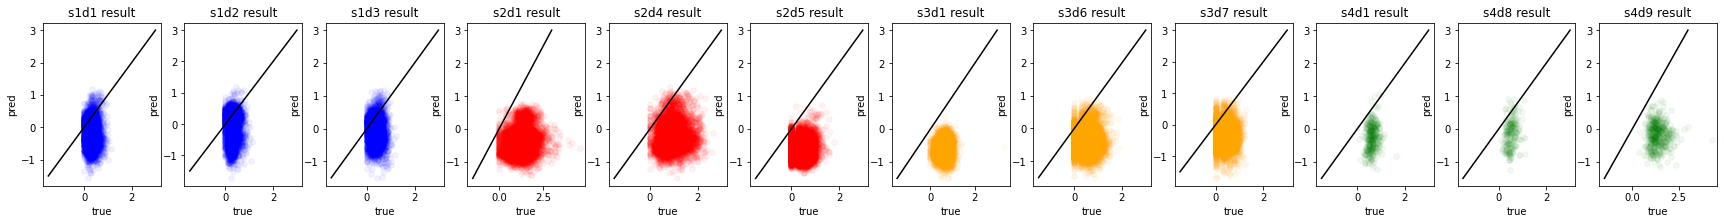

Epoch  100 s1d1:  0.20591742 s1d2:  0.20716742 s1d3:  0.24113987 s2d1: 1.5032457 s2d4: 0.8885476 s2d5: 0.8862847 s3d1: 1.333157 s3d6: 0.81473786 s3d7: 0.5775811 s4d1: 0.52464604 s4d8: 0.37136167 s4d9: 1.2696093 test loss: 0.9275492562645355
Epoch  200 s1d1:  0.1874897 s1d2:  0.19000074 s1d3:  0.22323732 s2d1: 1.4157099 s2d4: 0.8671717 s2d5: 0.7962454 s3d1: 1.1965764 s3d6: 0.7403457 s3d7: 0.5158432 s4d1: 0.4851004 s4d8: 0.36494368 s4d9: 1.2416782 test loss: 0.9021290440610796
Epoch  300 s1d1:  0.17964631 s1d2:  0.18289147 s1d3:  0.21353139 s2d1: 1.3611672 s2d4: 0.85207576 s2d5: 0.7399077 s3d1: 1.1019083 s3d6: 0.6931208 s3d7: 0.47721773 s4d1: 0.46069056 s4d8: 0.3600459 s4d9: 1.2230873 test loss: 0.8856401341621792
Epoch  400 s1d1:  0.17561132 s1d2:  0.17907727 s1d3:  0.20717317 s2d1: 1.3216938 s2d4: 0.8411773 s2d5: 0.69944274 s3d1: 1.0353397 s3d6: 0.659117 s3d7: 0.44983965 s4d1: 0.4438484 s4d8: 0.3568748 s4d9: 1.2096606 test loss: 0.8739604780569045
Epoch  500 s1d1:  0.17327745 s1d2:  0.

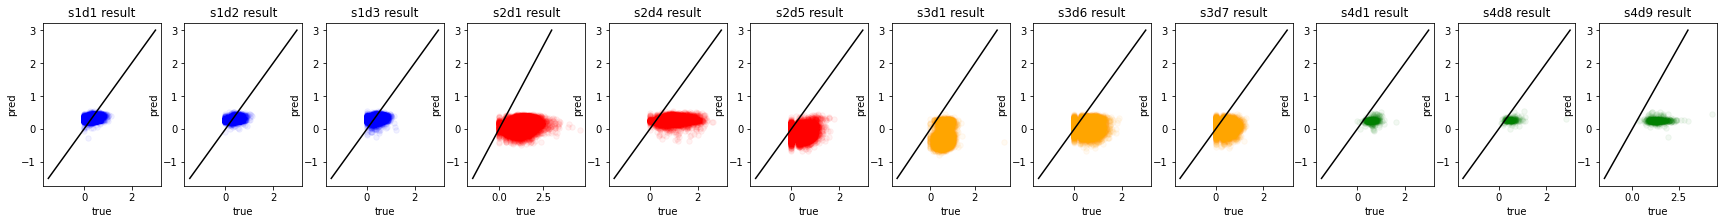

Epoch  1100 s1d1:  0.16938221 s1d2:  0.17117225 s1d3:  0.19386575 s2d1: 1.2109723 s2d4: 0.815991 s2d5: 0.5905157 s3d1: 0.85249394 s3d6: 0.56842494 s3d7: 0.38132414 s4d1: 0.40229154 s4d8: 0.35069826 s4d9: 1.1725631 test loss: 0.8429672840050861
Epoch  1200 s1d1:  0.1692284 s1d2:  0.17102833 s1d3:  0.19384645 s2d1: 1.2058005 s2d4: 0.81602675 s2d5: 0.5854384 s3d1: 0.8428703 s3d6: 0.5643752 s3d7: 0.37841597 s4d1: 0.40126133 s4d8: 0.3510742 s4d9: 1.171459 test loss: 0.8421306588581359
Epoch  1300 s1d1:  0.16907248 s1d2:  0.17073739 s1d3:  0.1933924 s2d1: 1.2017757 s2d4: 0.8150762 s2d5: 0.5818425 s3d1: 0.8360639 s3d6: 0.561488 s3d7: 0.37633497 s4d1: 0.399953 s4d8: 0.3505926 s4d9: 1.1699505 test loss: 0.8409178507163209
Epoch  1400 s1d1:  0.16894853 s1d2:  0.17054795 s1d3:  0.1931906 s2d1: 1.1988517 s2d4: 0.8148669 s2d5: 0.5791964 s3d1: 0.83165723 s3d6: 0.5595631 s3d7: 0.3749499 s4d1: 0.39946473 s4d8: 0.35066313 s4d9: 1.169268 test loss: 0.8404105660969174
Epoch  1500 s1d1:  0.16887195 s1d2: 

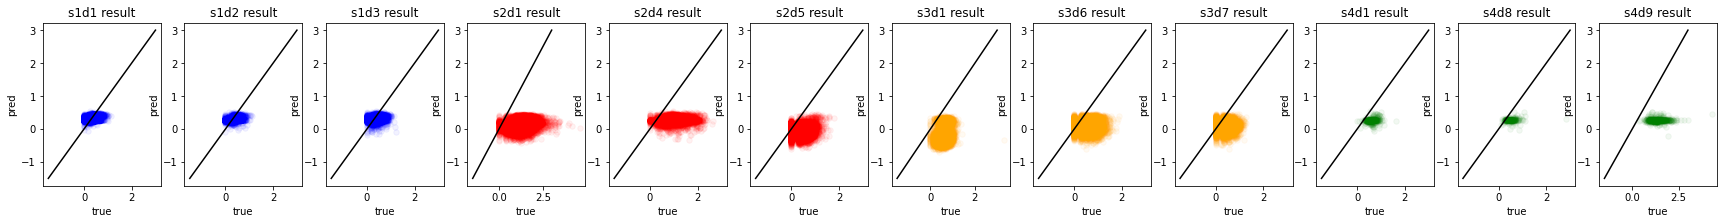

Epoch  2100 s1d1:  0.16838245 s1d2:  0.17069075 s1d3:  0.19443582 s2d1: 1.1837234 s2d4: 0.81718683 s2d5: 0.56201047 s3d1: 0.8051108 s3d6: 0.5485033 s3d7: 0.3663263 s4d1: 0.39847398 s4d8: 0.35233942 s4d9: 1.1670434 test loss: 0.8389781029130484
Epoch  2200 s1d1:  0.1682867 s1d2:  0.17082685 s1d3:  0.19492963 s2d1: 1.1816397 s2d4: 0.81766945 s2d5: 0.5591693 s3d1: 0.8004154 s3d6: 0.54683685 s3d7: 0.36479953 s4d1: 0.3983191 s4d8: 0.35258946 s4d9: 1.1667141 test loss: 0.838764956882984
Epoch  2300 s1d1:  0.16821077 s1d2:  0.17104523 s1d3:  0.19561957 s2d1: 1.1799266 s2d4: 0.81836826 s2d5: 0.5566564 s3d1: 0.7960158 s3d6: 0.5454148 s3d7: 0.3635301 s4d1: 0.39840087 s4d8: 0.3529812 s4d9: 1.1666331 test loss: 0.8387603693177579
Epoch  2400 s1d1:  0.168135 s1d2:  0.17104696 s1d3:  0.19576284 s2d1: 1.1784298 s2d4: 0.818645 s2d5: 0.5543841 s3d1: 0.7916005 s3d6: 0.54452616 s3d7: 0.36254296 s4d1: 0.3984686 s4d8: 0.3530708 s4d9: 1.1665564 test loss: 0.8387299312704156
Epoch  2500 s1d1:  0.16807817 s1d

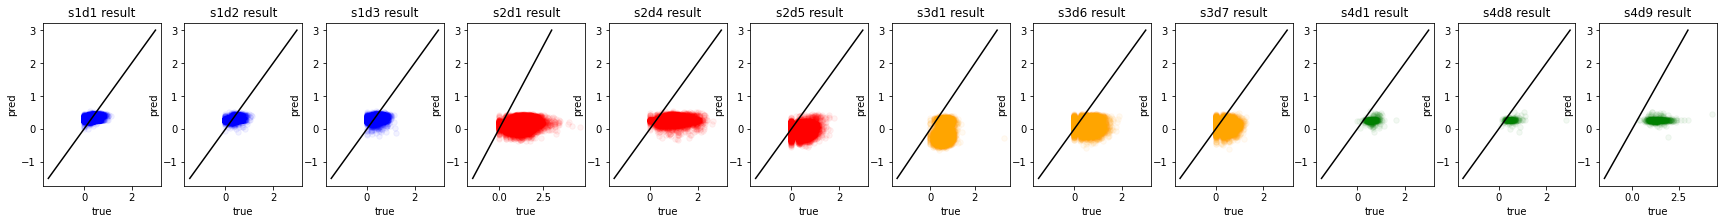

Epoch  3100 s1d1:  0.16771145 s1d2:  0.17122534 s1d3:  0.19659518 s2d1: 1.1711072 s2d4: 0.8212748 s2d5: 0.5423941 s3d1: 0.77009594 s3d6: 0.5406362 s3d7: 0.35752967 s4d1: 0.39988536 s4d8: 0.35390025 s4d9: 1.1669607 test loss: 0.8392854951514738
Epoch  3200 s1d1:  0.16766927 s1d2:  0.17123838 s1d3:  0.19661759 s2d1: 1.1701791 s2d4: 0.8218088 s2d5: 0.5406631 s3d1: 0.76624244 s3d6: 0.54038495 s3d7: 0.357019 s4d1: 0.40025753 s4d8: 0.3541337 s4d9: 1.1672364 test loss: 0.8395410881090816
Epoch  3300 s1d1:  0.16763604 s1d2:  0.17128755 s1d3:  0.19672576 s2d1: 1.169542 s2d4: 0.82239115 s2d5: 0.53923464 s3d1: 0.7632826 s3d6: 0.54022384 s3d7: 0.3566483 s4d1: 0.40058422 s4d8: 0.3544387 s4d9: 1.1675469 test loss: 0.8398178578932131
Epoch  3400 s1d1:  0.16757366 s1d2:  0.17126757 s1d3:  0.19672914 s2d1: 1.1687819 s2d4: 0.8227352 s2d5: 0.5378926 s3d1: 0.76020056 s3d6: 0.54004395 s3d7: 0.35622504 s4d1: 0.40084475 s4d8: 0.35472733 s4d9: 1.167789 test loss: 0.8400390849660033
Epoch  3500 s1d1:  0.167511

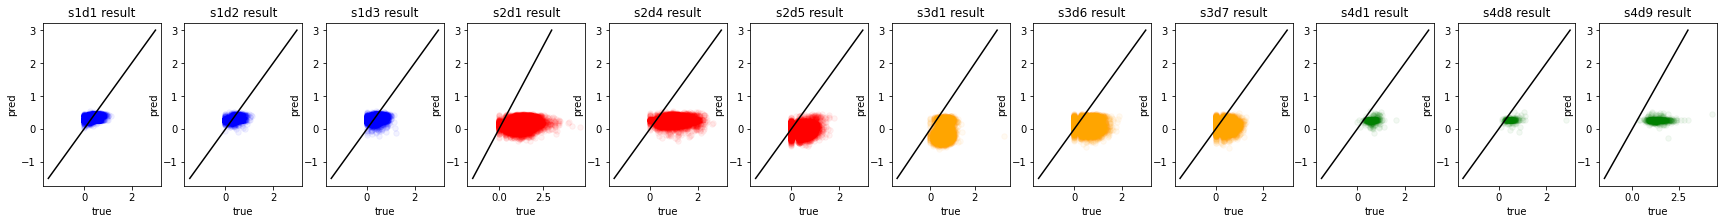

Epoch  4100 s1d1:  0.16719942 s1d2:  0.17148033 s1d3:  0.19737461 s2d1: 1.1641358 s2d4: 0.8269739 s2d5: 0.5275419 s3d1: 0.7399678 s3d6: 0.5386658 s3d7: 0.35396424 s4d1: 0.4024913 s4d8: 0.3563449 s4d9: 1.1692789 test loss: 0.841393919768525
Epoch  4200 s1d1:  0.16712604 s1d2:  0.17141552 s1d3:  0.19721615 s2d1: 1.1635225 s2d4: 0.8268253 s2d5: 0.52678376 s3d1: 0.7392102 s3d6: 0.5385327 s3d7: 0.3541728 s4d1: 0.40203816 s4d8: 0.35601386 s4d9: 1.1688288 test loss: 0.8410054800499833
Epoch  4300 s1d1:  0.1671037 s1d2:  0.17144905 s1d3:  0.19724265 s2d1: 1.16322 s2d4: 0.8270314 s2d5: 0.52623755 s3d1: 0.7387702 s3d6: 0.5386208 s3d7: 0.35438073 s4d1: 0.4019727 s4d8: 0.35599083 s4d9: 1.1688373 test loss: 0.840998414842887
Epoch  4400 s1d1:  0.16704111 s1d2:  0.17140444 s1d3:  0.19715627 s2d1: 1.1626811 s2d4: 0.8269806 s2d5: 0.5254859 s3d1: 0.738166 s3d6: 0.53857684 s3d7: 0.3544079 s4d1: 0.40170765 s4d8: 0.3558002 s4d9: 1.1686094 test loss: 0.8407940082843934
Epoch  4500 s1d1:  0.16701804 s1d2:  

In [33]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s1d1, pro_s1d1)

Epoch  0 s1d1:  0.67839336 s1d2:  0.63308054 s1d3:  0.5806681 s2d1: 1.7321424 s2d4: 1.3054903 s2d5: 1.0974491 s3d1: 1.217079 s3d6: 1.0124882 s3d7: 0.8651054 s4d1: 0.9624245 s4d8: 0.79833984 s4d9: 1.636664 test loss: 1.2925985659899306


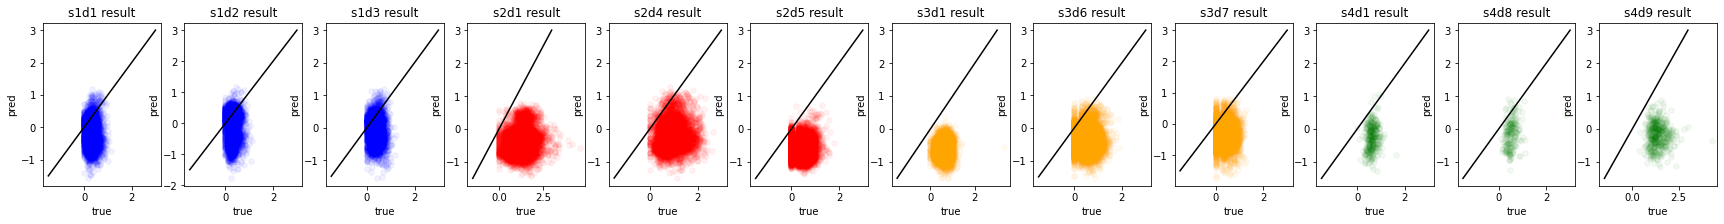

Epoch  100 s1d1:  0.23153257 s1d2:  0.19953127 s1d3:  0.26631743 s2d1: 1.5931334 s2d4: 0.9237861 s2d5: 0.8616792 s3d1: 1.4470906 s3d6: 0.8441011 s3d7: 0.5977715 s4d1: 0.56870663 s4d8: 0.393449 s4d9: 1.3023031 test loss: 0.958399531587513
Epoch  200 s1d1:  0.2069139 s1d2:  0.18320508 s1d3:  0.2407302 s2d1: 1.5267906 s2d4: 0.8947646 s2d5: 0.78631467 s3d1: 1.3699846 s3d6: 0.77528375 s3d7: 0.53577924 s4d1: 0.51594836 s4d8: 0.37474537 s4d9: 1.2595365 test loss: 0.919866268542621
Epoch  300 s1d1:  0.19552536 s1d2:  0.17585234 s1d3:  0.22704735 s2d1: 1.4829816 s2d4: 0.8747676 s2d5: 0.7394489 s3d1: 1.313483 s3d6: 0.7304425 s3d7: 0.49603513 s4d1: 0.48634917 s4d8: 0.3639892 s4d9: 1.2359492 test loss: 0.8986560538871708
Epoch  400 s1d1:  0.1885692 s1d2:  0.17176919 s1d3:  0.21800596 s2d1: 1.4489417 s2d4: 0.8602761 s2d5: 0.70471853 s3d1: 1.2653648 s3d6: 0.6971939 s3d7: 0.46715906 s4d1: 0.46692044 s4d8: 0.35819232 s4d9: 1.2208735 test loss: 0.885172058024915
Epoch  500 s1d1:  0.1841262 s1d2:  0.169

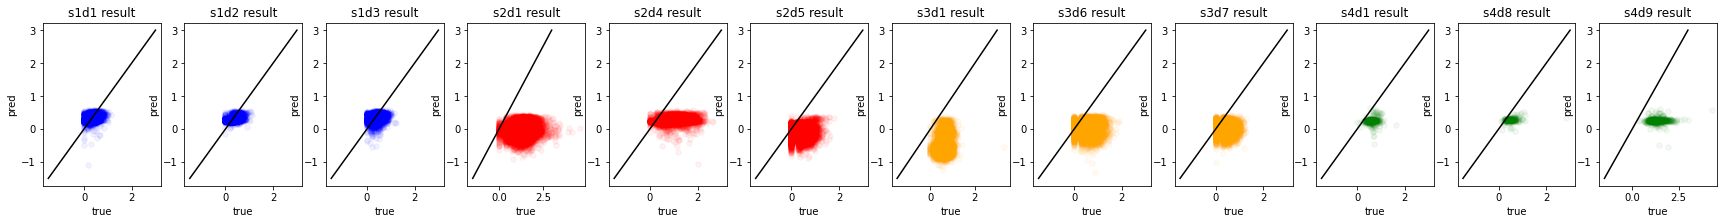

Epoch  1100 s1d1:  0.17542093 s1d2:  0.1647743 s1d3:  0.1959601 s2d1: 1.3365965 s2d4: 0.81440336 s2d5: 0.59704536 s3d1: 1.105807 s3d6: 0.5976916 s3d7: 0.38642544 s4d1: 0.4127082 s4d8: 0.3429269 s4d9: 1.1757404 test loss: 0.8460131355699567
Epoch  1200 s1d1:  0.17514165 s1d2:  0.16456601 s1d3:  0.19519983 s2d1: 1.3302903 s2d4: 0.8123903 s2d5: 0.59109724 s3d1: 1.0948248 s3d6: 0.5932127 s3d7: 0.38283032 s4d1: 0.41066584 s4d8: 0.34247503 s4d9: 1.1737938 test loss: 0.8444011083243566
Epoch  1300 s1d1:  0.17484377 s1d2:  0.16443288 s1d3:  0.19462773 s2d1: 1.3254118 s2d4: 0.8111243 s2d5: 0.5866438 s3d1: 1.0867484 s3d6: 0.5897194 s3d7: 0.38013437 s4d1: 0.4092068 s4d8: 0.3422727 s4d9: 1.1724199 test loss: 0.8432706956634083
Epoch  1400 s1d1:  0.17464061 s1d2:  0.16432561 s1d3:  0.19409308 s2d1: 1.321151 s2d4: 0.80984944 s2d5: 0.58273 s3d1: 1.0810864 s3d6: 0.5865593 s3d7: 0.37779978 s4d1: 0.40767995 s4d8: 0.3419683 s4d9: 1.171086 test loss: 0.8421465804150647
Epoch  1500 s1d1:  0.17454392 s1d2: 

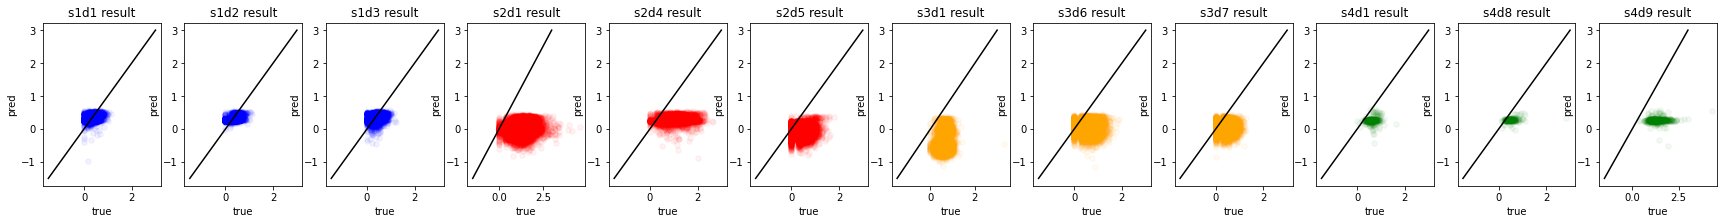

Epoch  2100 s1d1:  0.17406991 s1d2:  0.16382591 s1d3:  0.1927578 s2d1: 1.3014323 s2d4: 0.8070987 s2d5: 0.5624823 s3d1: 1.0505623 s3d6: 0.57397884 s3d7: 0.3690905 s4d1: 0.40529582 s4d8: 0.34221414 s4d9: 1.169229 test loss: 0.840597167108252
Epoch  2200 s1d1:  0.1740027 s1d2:  0.1637632 s1d3:  0.19266966 s2d1: 1.2993845 s2d4: 0.8068977 s2d5: 0.5603373 s3d1: 1.0475417 s3d6: 0.5728258 s3d7: 0.36835706 s4d1: 0.4051469 s4d8: 0.34226373 s4d9: 1.1692529 test loss: 0.8405926022127341
Epoch  2300 s1d1:  0.17393331 s1d2:  0.16371194 s1d3:  0.19255663 s2d1: 1.2975196 s2d4: 0.80668896 s2d5: 0.55834687 s3d1: 1.0448898 s3d6: 0.5717025 s3d7: 0.36759627 s4d1: 0.40494904 s4d8: 0.3421944 s4d9: 1.1690881 test loss: 0.8404497121836192
Epoch  2400 s1d1:  0.17388979 s1d2:  0.16365984 s1d3:  0.19243596 s2d1: 1.2958657 s2d4: 0.806589 s2d5: 0.55668813 s3d1: 1.0427282 s3d6: 0.5707812 s3d7: 0.36707735 s4d1: 0.4048172 s4d8: 0.34221295 s4d9: 1.1690137 test loss: 0.8403825663699471
Epoch  2500 s1d1:  0.17381191 s1d2

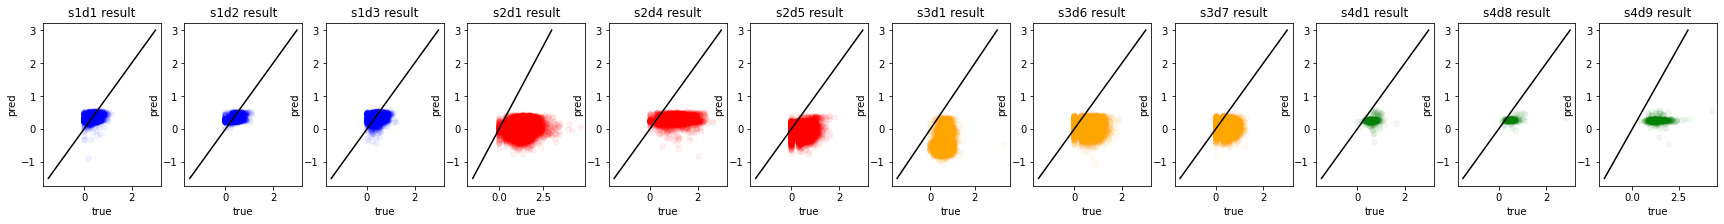

Epoch  3100 s1d1:  0.17361794 s1d2:  0.16337802 s1d3:  0.1917991 s2d1: 1.2866645 s2d4: 0.8059792 s2d5: 0.54808956 s3d1: 1.0323001 s3d6: 0.5657818 s3d7: 0.3648286 s4d1: 0.4037348 s4d8: 0.3424846 s4d9: 1.1683545 test loss: 0.8398105607061841
Epoch  3200 s1d1:  0.17355633 s1d2:  0.16334963 s1d3:  0.19171675 s2d1: 1.2856854 s2d4: 0.80599093 s2d5: 0.5472137 s3d1: 1.0314947 s3d6: 0.565234 s3d7: 0.36458972 s4d1: 0.40359697 s4d8: 0.34251562 s4d9: 1.16829 test loss: 0.8397498710415171
Epoch  3300 s1d1:  0.17354925 s1d2:  0.16330977 s1d3:  0.1916598 s2d1: 1.2845362 s2d4: 0.8057604 s2d5: 0.546207 s3d1: 1.029907 s3d6: 0.5646917 s3d7: 0.36438137 s4d1: 0.40342724 s4d8: 0.3424576 s4d9: 1.1681756 test loss: 0.8396446513844624
Epoch  3400 s1d1:  0.17354278 s1d2:  0.16327734 s1d3:  0.19168133 s2d1: 1.2836018 s2d4: 0.8058171 s2d5: 0.5453078 s3d1: 1.0281678 s3d6: 0.56430995 s3d7: 0.36424643 s4d1: 0.40362737 s4d8: 0.34272307 s4d9: 1.1683828 test loss: 0.8398314980699966
Epoch  3500 s1d1:  0.17359464 s1d2: 

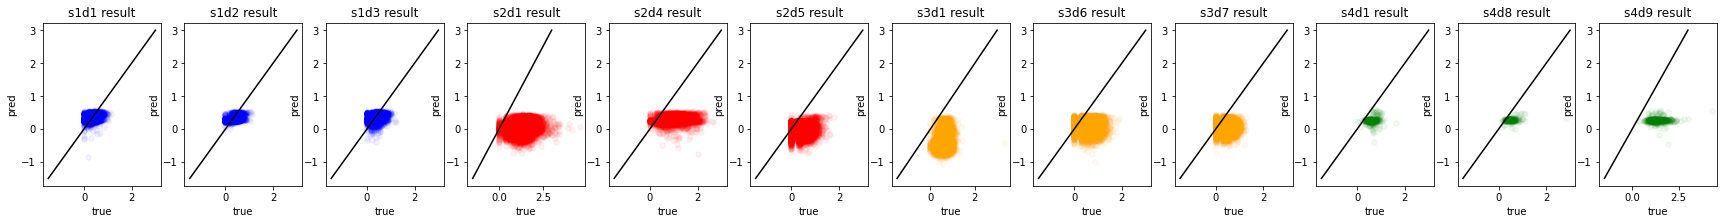

Epoch  4100 s1d1:  0.173595 s1d2:  0.16303828 s1d3:  0.19161464 s2d1: 1.2766914 s2d4: 0.80600494 s2d5: 0.5375291 s3d1: 1.0156077 s3d6: 0.5618607 s3d7: 0.36285263 s4d1: 0.40426597 s4d8: 0.3432065 s4d9: 1.1686635 test loss: 0.8401541920367663
Epoch  4200 s1d1:  0.17357564 s1d2:  0.16301143 s1d3:  0.1915887 s2d1: 1.2756543 s2d4: 0.8060384 s2d5: 0.5364219 s3d1: 1.0138624 s3d6: 0.5615548 s3d7: 0.36266154 s4d1: 0.40433186 s4d8: 0.34323442 s4d9: 1.1686759 test loss: 0.8401750583141432
Epoch  4300 s1d1:  0.17361222 s1d2:  0.16296828 s1d3:  0.19161013 s2d1: 1.2746054 s2d4: 0.80634195 s2d5: 0.535338 s3d1: 1.0114408 s3d6: 0.5615591 s3d7: 0.36266112 s4d1: 0.40468997 s4d8: 0.34341502 s4d9: 1.1688596 test loss: 0.8403651894384081
Epoch  4400 s1d1:  0.17353448 s1d2:  0.16294475 s1d3:  0.19158916 s2d1: 1.2735149 s2d4: 0.8066383 s2d5: 0.5341274 s3d1: 1.0093508 s3d6: 0.561413 s3d7: 0.36260375 s4d1: 0.4048681 s4d8: 0.34348434 s4d9: 1.1689932 test loss: 0.8404850319793863
Epoch  4500 s1d1:  0.1735317 s1d2

In [34]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s1d2, pro_s1d2)

Epoch  0 s1d1:  0.67622674 s1d2:  0.63881177 s1d3:  0.5745118 s2d1: 1.7307372 s2d4: 1.3074925 s2d5: 1.1014867 s3d1: 1.2123983 s3d6: 1.0150727 s3d7: 0.87166214 s4d1: 0.9633486 s4d8: 0.8025389 s4d9: 1.6360757 test loss: 1.293024802545919


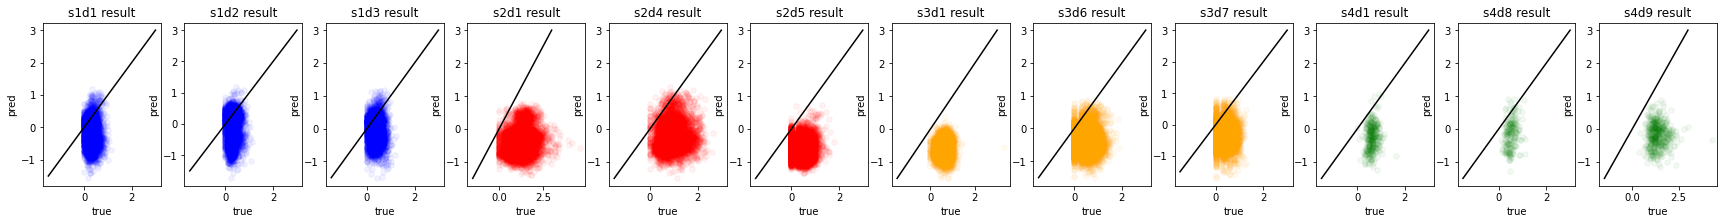

Epoch  100 s1d1:  0.21618813 s1d2:  0.22745107 s1d3:  0.22200248 s2d1: 1.4956558 s2d4: 0.86334 s2d5: 0.85362226 s3d1: 1.3157997 s3d6: 0.7633659 s3d7: 0.5624854 s4d1: 0.4852453 s4d8: 0.33181942 s4d9: 1.214494 test loss: 0.8823033374665088
Epoch  200 s1d1:  0.19411379 s1d2:  0.20801485 s1d3:  0.20216629 s2d1: 1.3953332 s2d4: 0.82766193 s2d5: 0.7565915 s3d1: 1.1841825 s3d6: 0.685088 s3d7: 0.49521783 s4d1: 0.43915665 s4d8: 0.31684712 s4d9: 1.1829077 test loss: 0.8529133329620809
Epoch  300 s1d1:  0.18536666 s1d2:  0.19452013 s1d3:  0.1940247 s2d1: 1.3338914 s2d4: 0.8131732 s2d5: 0.6972557 s3d1: 1.0908091 s3d6: 0.63775706 s3d7: 0.45811677 s4d1: 0.4176068 s4d8: 0.31505308 s4d9: 1.170485 test loss: 0.8412138360537972
Epoch  400 s1d1:  0.18078089 s1d2:  0.18644887 s1d3:  0.18929774 s2d1: 1.2913554 s2d4: 0.80309093 s2d5: 0.6552318 s3d1: 1.022076 s3d6: 0.6037839 s3d7: 0.432264 s4d1: 0.40222052 s4d8: 0.314846 s4d9: 1.1606396 test loss: 0.8323858519143341
Epoch  500 s1d1:  0.17814587 s1d2:  0.1814

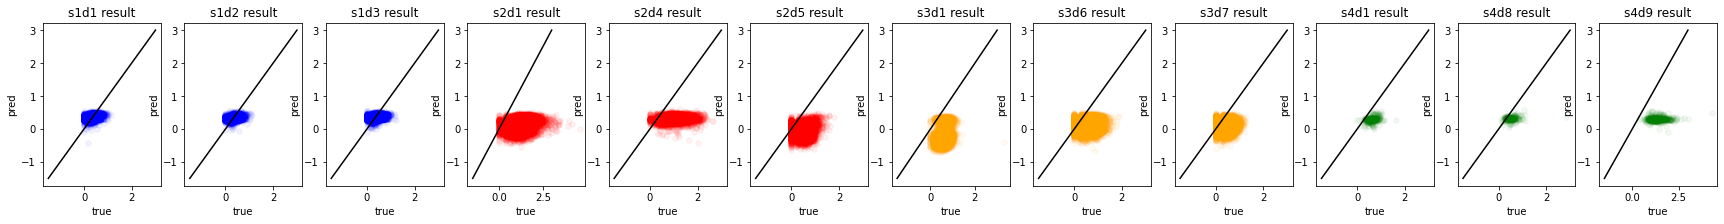

Epoch  1100 s1d1:  0.17511615 s1d2:  0.1723023 s1d3:  0.18172592 s2d1: 1.1786828 s2d4: 0.7822608 s2d5: 0.5509613 s3d1: 0.82022923 s3d6: 0.5202875 s3d7: 0.3737961 s4d1: 0.36751786 s4d8: 0.31847888 s4d9: 1.1339983 test loss: 0.8101610586792497
Epoch  1200 s1d1:  0.1750615 s1d2:  0.17184165 s1d3:  0.18153007 s2d1: 1.1727806 s2d4: 0.781539 s2d5: 0.5451127 s3d1: 0.80993164 s3d6: 0.5162683 s3d7: 0.37054166 s4d1: 0.36638844 s4d8: 0.31881997 s4d9: 1.1330699 test loss: 0.8094214027958937
Epoch  1300 s1d1:  0.17491359 s1d2:  0.17140794 s1d3:  0.1813565 s2d1: 1.1676391 s2d4: 0.7810108 s2d5: 0.53982335 s3d1: 0.80024564 s3d6: 0.5128993 s3d7: 0.36773005 s4d1: 0.36559492 s4d8: 0.3190619 s4d9: 1.1324669 test loss: 0.8089338341715141
Epoch  1400 s1d1:  0.17494394 s1d2:  0.17112766 s1d3:  0.1812003 s2d1: 1.1625955 s2d4: 0.7802615 s2d5: 0.5342857 s3d1: 0.7905095 s3d6: 0.50951284 s3d7: 0.3645317 s4d1: 0.36482248 s4d8: 0.31922254 s4d9: 1.1319253 test loss: 0.8084824383500891
Epoch  1500 s1d1:  0.17493142 s

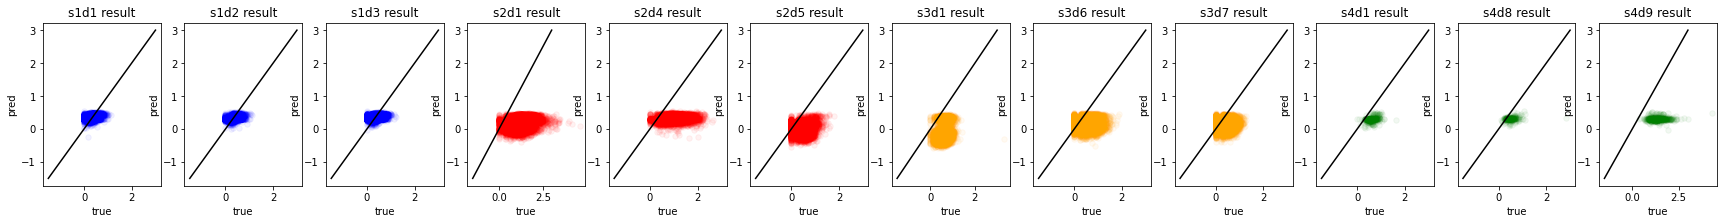

Epoch  2100 s1d1:  0.17482772 s1d2:  0.16997175 s1d3:  0.18050355 s2d1: 1.140104 s2d4: 0.7779205 s2d5: 0.5099367 s3d1: 0.7444786 s3d6: 0.49520573 s3d7: 0.3523574 s4d1: 0.36193624 s4d8: 0.31976172 s4d9: 1.1297823 test loss: 0.8067154573038654
Epoch  2200 s1d1:  0.17475416 s1d2:  0.16993487 s1d3:  0.180476 s2d1: 1.1380775 s2d4: 0.7782011 s2d5: 0.5072217 s3d1: 0.74001 s3d6: 0.49377072 s3d7: 0.35114157 s4d1: 0.36188006 s4d8: 0.3200364 s4d9: 1.1298574 test loss: 0.8067778802113067
Epoch  2300 s1d1:  0.17480934 s1d2:  0.16986705 s1d3:  0.18039759 s2d1: 1.1356465 s2d4: 0.7777478 s2d5: 0.5046574 s3d1: 0.734863 s3d6: 0.4923507 s3d7: 0.35007656 s4d1: 0.36143738 s4d8: 0.31986895 s4d9: 1.1294508 test loss: 0.8064364278511332
Epoch  2400 s1d1:  0.17480157 s1d2:  0.16979624 s1d3:  0.18034083 s2d1: 1.1337142 s2d4: 0.77769864 s2d5: 0.50238836 s3d1: 0.7305063 s3d6: 0.49123758 s3d7: 0.34915358 s4d1: 0.3613402 s4d8: 0.3199791 s4d9: 1.129457 test loss: 0.806434929545981
Epoch  2500 s1d1:  0.1748043 s1d2: 

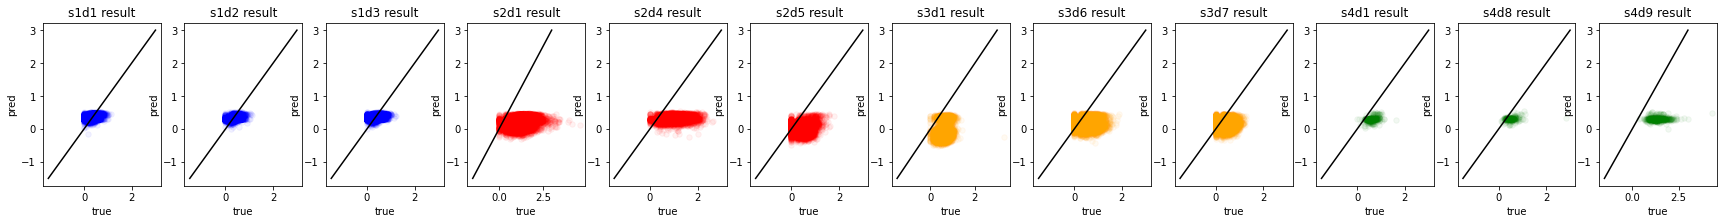

Epoch  3100 s1d1:  0.17479366 s1d2:  0.16950285 s1d3:  0.17999522 s2d1: 1.1204362 s2d4: 0.77716947 s2d5: 0.48697084 s3d1: 0.7012858 s3d6: 0.48304403 s3d7: 0.3427939 s4d1: 0.35989484 s4d8: 0.31998536 s4d9: 1.12834 test loss: 0.8055013072559261
Epoch  3200 s1d1:  0.17480397 s1d2:  0.16947426 s1d3:  0.1799642 s2d1: 1.1188949 s2d4: 0.7773249 s2d5: 0.48504546 s3d1: 0.6973424 s3d6: 0.48211274 s3d7: 0.34213147 s4d1: 0.3598532 s4d8: 0.3201377 s4d9: 1.1283785 test loss: 0.8055323846888347
Epoch  3300 s1d1:  0.17476407 s1d2:  0.1694262 s1d3:  0.1799194 s2d1: 1.1172589 s2d4: 0.7772729 s2d5: 0.48296934 s3d1: 0.6930757 s3d6: 0.48106 s3d7: 0.3412724 s4d1: 0.35966727 s4d8: 0.32013524 s4d9: 1.1282803 test loss: 0.8054413025542695
Epoch  3400 s1d1:  0.17473948 s1d2:  0.16935457 s1d3:  0.17987324 s2d1: 1.1158109 s2d4: 0.7773253 s2d5: 0.48107988 s3d1: 0.68924445 s3d6: 0.48016948 s3d7: 0.34049428 s4d1: 0.35965398 s4d8: 0.3202967 s4d9: 1.1283413 test loss: 0.8054918413802031
Epoch  3500 s1d1:  0.17472892 s

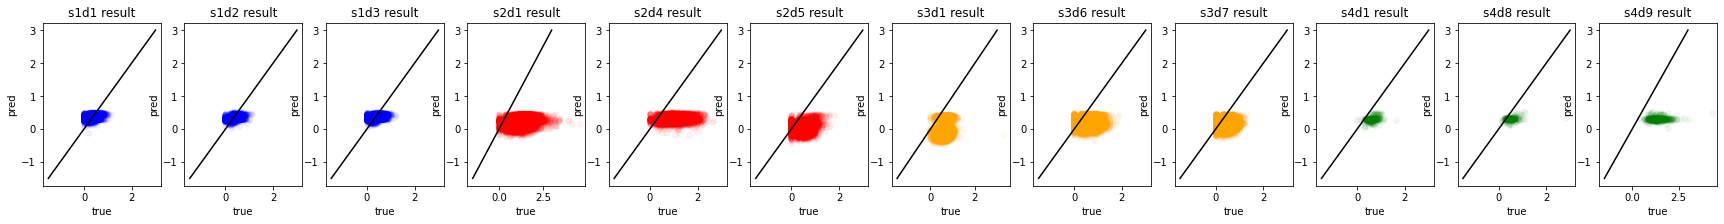

Epoch  4100 s1d1:  0.17467496 s1d2:  0.16913569 s1d3:  0.1796496 s2d1: 1.1067711 s2d4: 0.77818793 s2d5: 0.4690431 s3d1: 0.66409993 s3d6: 0.47420385 s3d7: 0.33562982 s4d1: 0.35931104 s4d8: 0.32086352 s4d9: 1.1279751 test loss: 0.8052519363143842
Epoch  4200 s1d1:  0.1747126 s1d2:  0.16912432 s1d3:  0.17962594 s2d1: 1.1057895 s2d4: 0.7782418 s2d5: 0.46777362 s3d1: 0.66192913 s3d6: 0.4735194 s3d7: 0.33518708 s4d1: 0.35920867 s4d8: 0.32089767 s4d9: 1.1278937 test loss: 0.8051871755104903
Epoch  4300 s1d1:  0.17472596 s1d2:  0.16909063 s1d3:  0.17958272 s2d1: 1.1046766 s2d4: 0.77796715 s2d5: 0.46655357 s3d1: 0.6595308 s3d6: 0.47278622 s3d7: 0.33471942 s4d1: 0.35898107 s4d8: 0.32076457 s4d9: 1.1277568 test loss: 0.8050542831314749
Epoch  4400 s1d1:  0.1747021 s1d2:  0.1690535 s1d3:  0.17955583 s2d1: 1.1037896 s2d4: 0.7781012 s2d5: 0.46553454 s3d1: 0.6572616 s3d6: 0.47224405 s3d7: 0.33449703 s4d1: 0.3589923 s4d8: 0.32082283 s4d9: 1.1277484 test loss: 0.8050553236753608
Epoch  4500 s1d1:  0.17

In [35]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s1d3, pro_s1d3)

Epoch  0 s1d1:  0.6795678 s1d2:  0.6404295 s1d3:  0.57825524 s2d1: 1.7109205 s2d4: 1.3061063 s2d5: 1.0823113 s3d1: 1.1807035 s3d6: 1.0026897 s3d7: 0.8597921 s4d1: 0.96520835 s4d8: 0.81057024 s4d9: 1.6387074 test loss: 1.296051137107563


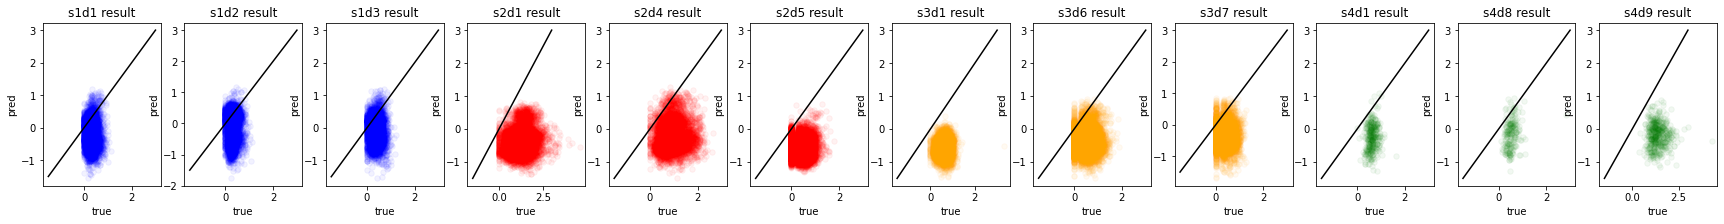

Epoch  100 s1d1:  0.42168525 s1d2:  0.52366084 s1d3:  0.46638414 s2d1: 0.5419307 s2d4: 0.7690997 s2d5: 0.62153846 s3d1: 0.57650036 s3d6: 0.52648956 s3d7: 0.47192323 s4d1: 0.48124433 s4d8: 0.7946322 s4d9: 1.2853583 test loss: 0.9830545523218726
Epoch  200 s1d1:  0.44883057 s1d2:  0.43478778 s1d3:  0.48989394 s2d1: 0.5052745 s2d4: 0.669121 s2d5: 0.6775985 s3d1: 0.5772936 s3d6: 0.54258835 s3d7: 0.55066526 s4d1: 0.3899853 s4d8: 0.67940545 s4d9: 1.1719992 test loss: 0.8813746424720114
Epoch  300 s1d1:  0.47471362 s1d2:  0.40978825 s1d3:  0.5173772 s2d1: 0.49937034 s2d4: 0.6412767 s2d5: 0.6928154 s3d1: 0.58261085 s3d6: 0.5555359 s3d7: 0.5719702 s4d1: 0.36479408 s4d8: 0.6447677 s4d9: 1.1301408 test loss: 0.8466080987885934
Epoch  400 s1d1:  0.49632084 s1d2:  0.3967916 s1d3:  0.5376972 s2d1: 0.49662077 s2d4: 0.62529945 s2d5: 0.70367867 s3d1: 0.5925773 s3d6: 0.5667232 s3d7: 0.58934295 s4d1: 0.35367385 s4d8: 0.6258091 s4d9: 1.1065626 test loss: 0.8275772048842808
Epoch  500 s1d1:  0.51235646 s1d

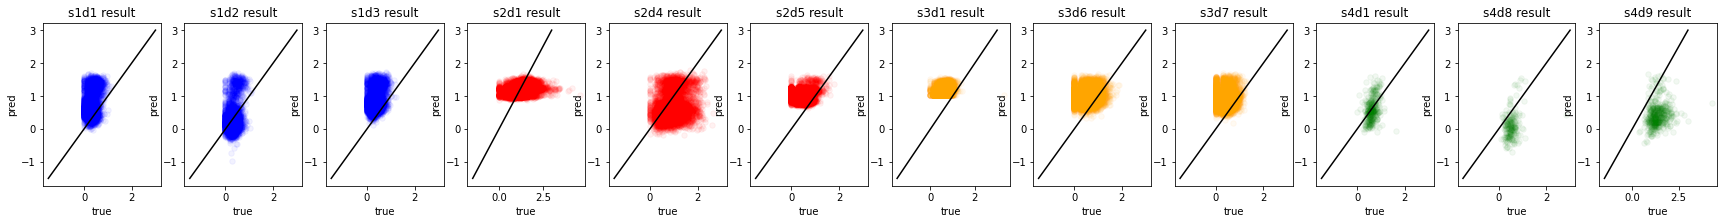

Epoch  1100 s1d1:  0.584352 s1d2:  0.3875934 s1d3:  0.62374884 s2d1: 0.4932652 s2d4: 0.6013466 s2d5: 0.7165355 s3d1: 0.63380694 s3d6: 0.59007746 s3d7: 0.61185145 s4d1: 0.35024872 s4d8: 0.5887906 s4d9: 1.0387357 test loss: 0.7797325840416459
Epoch  1200 s1d1:  0.5932369 s1d2:  0.3892328 s1d3:  0.63266283 s2d1: 0.49310267 s2d4: 0.6010316 s2d5: 0.7150996 s3d1: 0.6367245 s3d6: 0.5901648 s3d7: 0.60903573 s4d1: 0.35290384 s4d8: 0.58632946 s4d9: 1.031385 test loss: 0.7752568381746631
Epoch  1300 s1d1:  0.6026538 s1d2:  0.39086097 s1d3:  0.6435084 s2d1: 0.4929251 s2d4: 0.60095495 s2d5: 0.7135174 s3d1: 0.6395881 s3d6: 0.58977103 s3d7: 0.60445124 s4d1: 0.35624805 s4d8: 0.5803582 s4d9: 1.0193007 test loss: 0.7674625102130088
Epoch  1400 s1d1:  0.60816705 s1d2:  0.39285553 s1d3:  0.6510477 s2d1: 0.4928113 s2d4: 0.6018613 s2d5: 0.7129604 s3d1: 0.64233226 s3d6: 0.58961976 s3d7: 0.60189235 s4d1: 0.35955867 s4d8: 0.5778794 s4d9: 1.0126787 test loss: 0.7635572820088453
Epoch  1500 s1d1:  0.6127704 s1d2

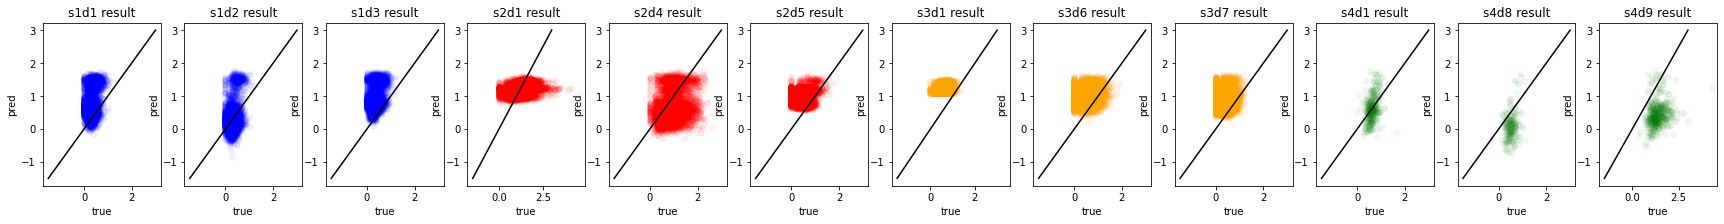

Epoch  2100 s1d1:  0.6251093 s1d2:  0.40265185 s1d3:  0.66540974 s2d1: 0.49200502 s2d4: 0.61496043 s2d5: 0.7077696 s3d1: 0.6546781 s3d6: 0.5867634 s3d7: 0.5935832 s4d1: 0.3779794 s4d8: 0.60562795 s4d9: 1.0316734 test loss: 0.782418881742453
Epoch  2200 s1d1:  0.6261189 s1d2:  0.40146288 s1d3:  0.6654123 s2d1: 0.4918997 s2d4: 0.61429703 s2d5: 0.70796216 s3d1: 0.65662545 s3d6: 0.5870552 s3d7: 0.59444386 s4d1: 0.37734824 s4d8: 0.6052239 s4d9: 1.0324353 test loss: 0.7827135955933859
Epoch  2300 s1d1:  0.62804276 s1d2:  0.40120202 s1d3:  0.66684395 s2d1: 0.4917619 s2d4: 0.614197 s2d5: 0.708746 s3d1: 0.6590254 s3d6: 0.58776295 s3d7: 0.5954618 s4d1: 0.37740263 s4d8: 0.60530216 s4d9: 1.033267 test loss: 0.7832384904216098
Epoch  2400 s1d1:  0.6285752 s1d2:  0.40034628 s1d3:  0.6668858 s2d1: 0.49166316 s2d4: 0.6142037 s2d5: 0.7091523 s3d1: 0.66067886 s3d6: 0.5880173 s3d7: 0.596066 s4d1: 0.3773023 s4d8: 0.6064443 s4d9: 1.0350509 test loss: 0.7844853210186704
Epoch  2500 s1d1:  0.6294043 s1d2:  0

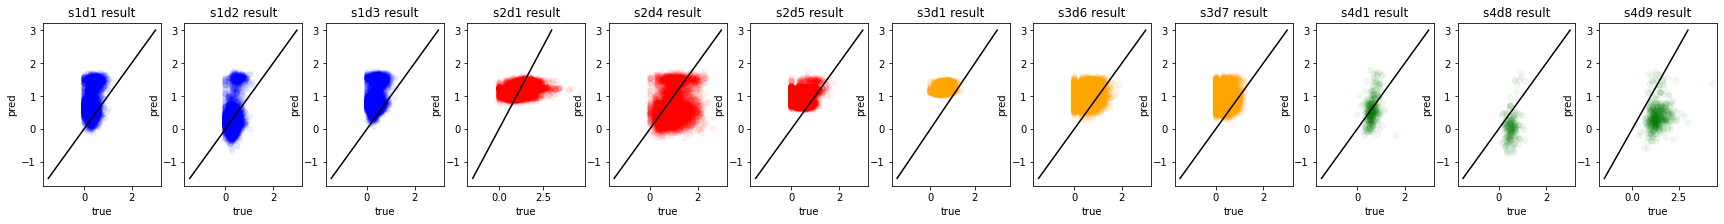

Epoch  3100 s1d1:  0.6280859 s1d2:  0.40187913 s1d3:  0.66456014 s2d1: 0.49089858 s2d4: 0.625295 s2d5: 0.70816535 s3d1: 0.66694725 s3d6: 0.5835612 s3d7: 0.59715736 s4d1: 0.3866906 s4d8: 0.6363668 s4d9: 1.0742884 test loss: 0.8145551015741367
Epoch  3200 s1d1:  0.62748474 s1d2:  0.40189767 s1d3:  0.6640238 s2d1: 0.49079305 s2d4: 0.62655044 s2d5: 0.70839655 s3d1: 0.6673037 s3d6: 0.58298707 s3d7: 0.59770644 s4d1: 0.38799727 s4d8: 0.6410043 s4d9: 1.0799845 test loss: 0.8189607842492074
Epoch  3300 s1d1:  0.6275554 s1d2:  0.40268287 s1d3:  0.6636141 s2d1: 0.49068183 s2d4: 0.6282539 s2d5: 0.70810485 s3d1: 0.6676176 s3d6: 0.58219767 s3d7: 0.5982024 s4d1: 0.38966358 s4d8: 0.6457031 s4d9: 1.0860908 test loss: 0.8236820352964831
Epoch  3400 s1d1:  0.626264 s1d2:  0.40242136 s1d3:  0.6621921 s2d1: 0.49059674 s2d4: 0.6295438 s2d5: 0.7079164 s3d1: 0.6674589 s3d6: 0.5811277 s3d7: 0.59845954 s4d1: 0.39066866 s4d8: 0.6509595 s4d9: 1.0926374 test loss: 0.8286565994511984
Epoch  3500 s1d1:  0.6261744 s1

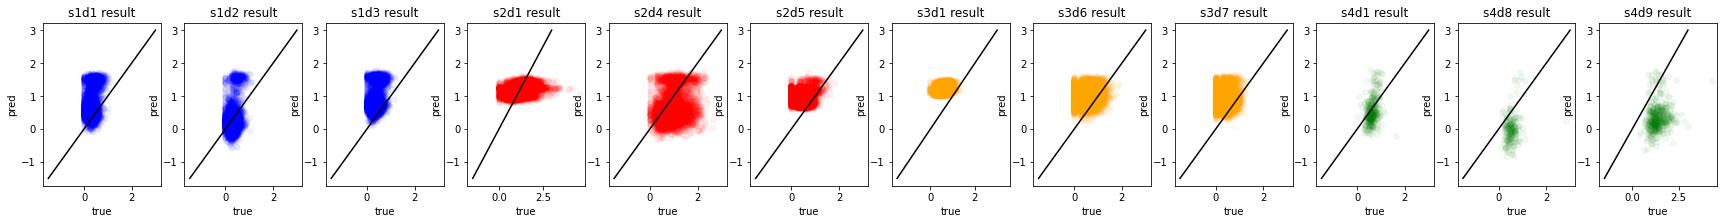

Epoch  4100 s1d1:  0.6216724 s1d2:  0.4070788 s1d3:  0.6544461 s2d1: 0.4899002 s2d4: 0.63725924 s2d5: 0.70714545 s3d1: 0.6638773 s3d6: 0.57562345 s3d7: 0.6018741 s4d1: 0.3992993 s4d8: 0.68716407 s4d9: 1.1362498 test loss: 0.8623197525972184
Epoch  4200 s1d1:  0.62135774 s1d2:  0.40896454 s1d3:  0.6534682 s2d1: 0.48981676 s2d4: 0.6392631 s2d5: 0.70741093 s3d1: 0.66353166 s3d6: 0.5752591 s3d7: 0.6022888 s4d1: 0.40163958 s4d8: 0.69367015 s4d9: 1.1424278 test loss: 0.8674922299964665
Epoch  4300 s1d1:  0.6208074 s1d2:  0.41091773 s1d3:  0.6529365 s2d1: 0.48971218 s2d4: 0.64124525 s2d5: 0.7075357 s3d1: 0.6630852 s3d6: 0.57470244 s3d7: 0.6023353 s4d1: 0.4041474 s4d8: 0.700352 s4d9: 1.1485634 test loss: 0.8726957086164623
Epoch  4400 s1d1:  0.62009406 s1d2:  0.41312462 s1d3:  0.6516556 s2d1: 0.48963004 s2d4: 0.6435905 s2d5: 0.707226 s3d1: 0.662417 s3d6: 0.5737068 s3d7: 0.6023771 s4d1: 0.40679154 s4d8: 0.7075773 s4d9: 1.1556797 test loss: 0.878604729740002
Epoch  4500 s1d1:  0.61989295 s1d2:  

In [36]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s2d1, pro_s2d1)

Epoch  0 s1d1:  0.69052124 s1d2:  0.6405365 s1d3:  0.59030116 s2d1: 1.7226188 s2d4: 1.3127506 s2d5: 1.0784374 s3d1: 1.1914593 s3d6: 1.0044204 s3d7: 0.85613286 s4d1: 0.96791303 s4d8: 0.8083322 s4d9: 1.6431047 test loss: 1.2989875661405035


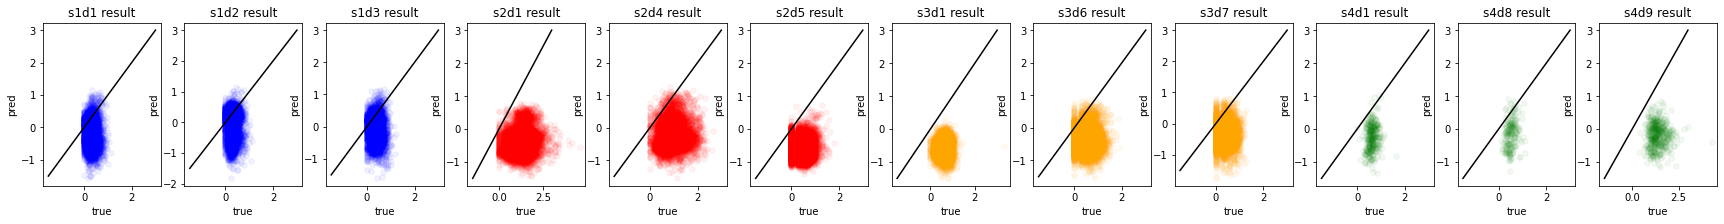

Epoch  100 s1d1:  0.5317875 s1d2:  0.43280885 s1d3:  0.5718319 s2d1: 1.0077337 s2d4: 0.9997996 s2d5: 0.3305411 s3d1: 0.33600518 s3d6: 0.42474455 s3d7: 0.30476442 s4d1: 0.63238907 s4d8: 0.6059 s4d9: 1.4226046 test loss: 1.0670007456688164
Epoch  200 s1d1:  0.37855196 s1d2:  0.32888234 s1d3:  0.4191416 s2d1: 0.9137963 s2d4: 0.85681707 s2d5: 0.2923091 s3d1: 0.26111606 s3d6: 0.37059543 s3d7: 0.2750405 s4d1: 0.5031855 s4d8: 0.49408856 s4d9: 1.2978421 test loss: 0.9530151449353668
Epoch  300 s1d1:  0.31901044 s1d2:  0.28860357 s1d3:  0.34788564 s2d1: 0.89186066 s2d4: 0.8097053 s2d5: 0.28627056 s3d1: 0.23973933 s3d6: 0.35740465 s3d7: 0.27403447 s4d1: 0.45707718 s4d8: 0.46410775 s4d9: 1.2627217 test loss: 0.9199054187590515
Epoch  400 s1d1:  0.2886188 s1d2:  0.26737243 s1d3:  0.31225768 s2d1: 0.887715 s2d4: 0.78663987 s2d5: 0.28463677 s3d1: 0.2341029 s3d6: 0.3515962 s3d7: 0.2727788 s4d1: 0.4325805 s4d8: 0.4460823 s4d9: 1.2404974 test loss: 0.9000086030532346
Epoch  500 s1d1:  0.27015215 s1d2: 

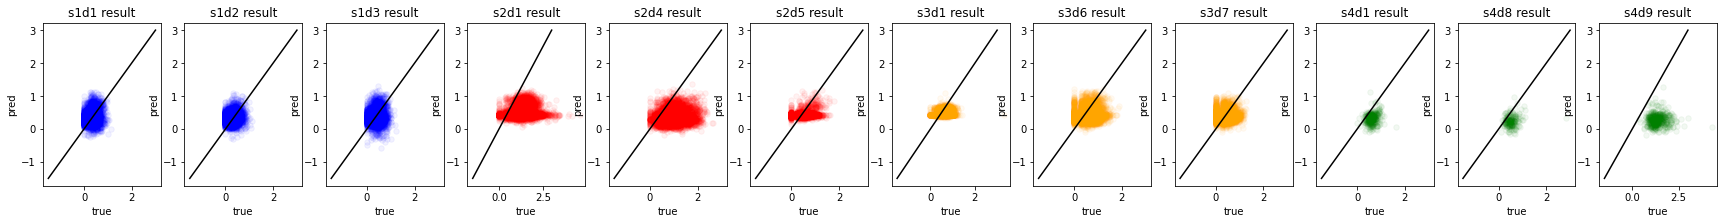

Epoch  1100 s1d1:  0.24401619 s1d2:  0.2269698 s1d3:  0.24976255 s2d1: 0.88516843 s2d4: 0.7289071 s2d5: 0.28164238 s3d1: 0.23247445 s3d6: 0.3402799 s3d7: 0.26868185 s4d1: 0.363867 s4d8: 0.39333302 s4d9: 1.1673217 test loss: 0.8376742786053428
Epoch  1200 s1d1:  0.24322814 s1d2:  0.22585693 s1d3:  0.24811631 s2d1: 0.8855929 s2d4: 0.72724307 s2d5: 0.28133312 s3d1: 0.2332334 s3d6: 0.3399155 s3d7: 0.2686764 s4d1: 0.36174032 s4d8: 0.3927249 s4d9: 1.1661166 test loss: 0.8365363831534841
Epoch  1300 s1d1:  0.24265033 s1d2:  0.22487119 s1d3:  0.24682754 s2d1: 0.8862878 s2d4: 0.72561127 s2d5: 0.28104177 s3d1: 0.23437093 s3d6: 0.33980218 s3d7: 0.26880863 s4d1: 0.3597053 s4d8: 0.39200515 s4d9: 1.1646525 test loss: 0.8352361974731093
Epoch  1400 s1d1:  0.24244274 s1d2:  0.22373897 s1d3:  0.24555661 s2d1: 0.88640356 s2d4: 0.7235805 s2d5: 0.28077936 s3d1: 0.23551457 s3d6: 0.3399698 s3d7: 0.26928532 s4d1: 0.3580088 s4d8: 0.39201155 s4d9: 1.1637423 test loss: 0.8344106663892457
Epoch  1500 s1d1:  0.24

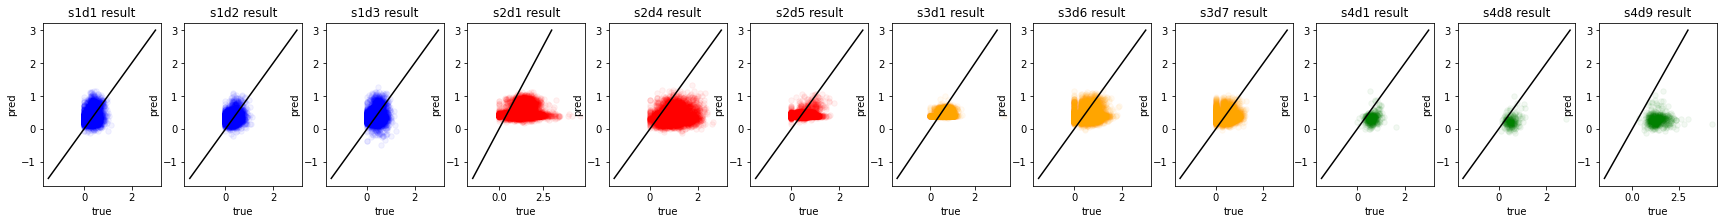

Epoch  2100 s1d1:  0.24001983 s1d2:  0.21701804 s1d3:  0.23985533 s2d1: 0.887619 s2d4: 0.7168185 s2d5: 0.27989405 s3d1: 0.2409627 s3d6: 0.3398783 s3d7: 0.27013704 s4d1: 0.3515002 s4d8: 0.39234775 s4d9: 1.1583009 test loss: 0.8300324076640181
Epoch  2200 s1d1:  0.24007183 s1d2:  0.21642089 s1d3:  0.23908503 s2d1: 0.88742083 s2d4: 0.71629673 s2d5: 0.2798104 s3d1: 0.24117595 s3d6: 0.3399452 s3d7: 0.27021107 s4d1: 0.3515081 s4d8: 0.39374763 s4d9: 1.159281 test loss: 0.8307984581492972
Epoch  2300 s1d1:  0.2398407 s1d2:  0.21586646 s1d3:  0.23837371 s2d1: 0.8875493 s2d4: 0.7156347 s2d5: 0.27974015 s3d1: 0.24145947 s3d6: 0.33984727 s3d7: 0.27007228 s4d1: 0.35086653 s4d8: 0.3940994 s4d9: 1.1590466 test loss: 0.8305922799271246
Epoch  2400 s1d1:  0.23974042 s1d2:  0.21539852 s1d3:  0.23791783 s2d1: 0.8874824 s2d4: 0.71513313 s2d5: 0.27967602 s3d1: 0.24164797 s3d6: 0.33977735 s3d7: 0.2700044 s4d1: 0.3505592 s4d8: 0.39466923 s4d9: 1.1591687 test loss: 0.8306831364490138
Epoch  2500 s1d1:  0.2394

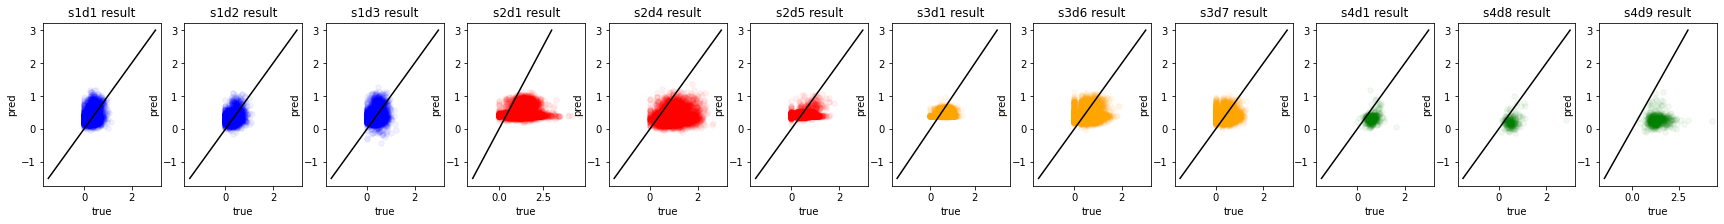

Epoch  3100 s1d1:  0.23998761 s1d2:  0.21368656 s1d3:  0.23626304 s2d1: 0.8870871 s2d4: 0.7137851 s2d5: 0.2792627 s3d1: 0.24309525 s3d6: 0.33953944 s3d7: 0.2699547 s4d1: 0.35008815 s4d8: 0.3994673 s4d9: 1.1616305 test loss: 0.8326676411188673
Epoch  3200 s1d1:  0.23992415 s1d2:  0.21372691 s1d3:  0.23608099 s2d1: 0.8873107 s2d4: 0.7136808 s2d5: 0.27921426 s3d1: 0.24334891 s3d6: 0.3394499 s3d7: 0.26987287 s4d1: 0.35014987 s4d8: 0.3999851 s4d9: 1.1620812 test loss: 0.8330163352861246
Epoch  3300 s1d1:  0.24048585 s1d2:  0.21367975 s1d3:  0.23613045 s2d1: 0.8871312 s2d4: 0.7132745 s2d5: 0.27916655 s3d1: 0.2434702 s3d6: 0.3395509 s3d7: 0.2699121 s4d1: 0.35022205 s4d8: 0.4007913 s4d9: 1.1624354 test loss: 0.8333334651122386
Epoch  3400 s1d1:  0.2407147 s1d2:  0.21358943 s1d3:  0.2361016 s2d1: 0.8870046 s2d4: 0.713132 s2d5: 0.27912614 s3d1: 0.2435561 s3d6: 0.3395365 s3d7: 0.2699263 s4d1: 0.35033032 s4d8: 0.4015981 s4d9: 1.1629151 test loss: 0.83373616472315
Epoch  3500 s1d1:  0.24104257 s1d2

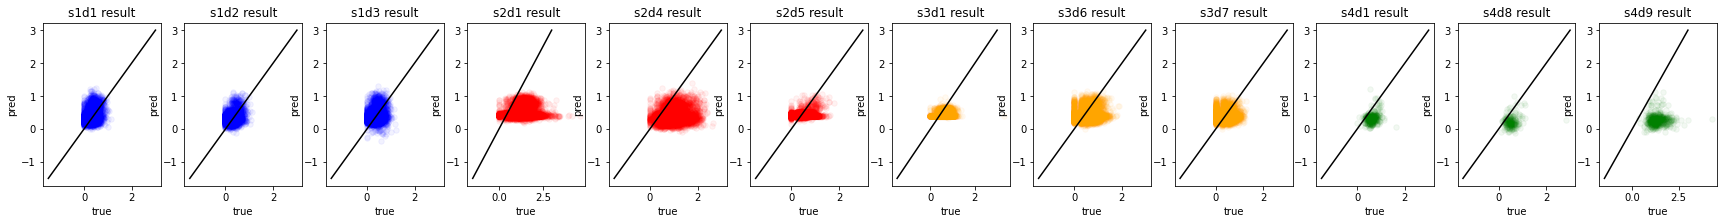

Epoch  4100 s1d1:  0.24344751 s1d2:  0.21384709 s1d3:  0.23676407 s2d1: 0.88622844 s2d4: 0.711959 s2d5: 0.27884236 s3d1: 0.24443872 s3d6: 0.3397594 s3d7: 0.27013078 s4d1: 0.35251984 s4d8: 0.40809956 s4d9: 1.1674618 test loss: 0.8376054754667221
Epoch  4200 s1d1:  0.24366543 s1d2:  0.21385932 s1d3:  0.23678184 s2d1: 0.88621265 s2d4: 0.7119972 s2d5: 0.2788114 s3d1: 0.2444927 s3d6: 0.33977824 s3d7: 0.2701156 s4d1: 0.35327807 s4d8: 0.40946996 s4d9: 1.1686732 test loss: 0.8386254107712657
Epoch  4300 s1d1:  0.24437611 s1d2:  0.21400087 s1d3:  0.23709051 s2d1: 0.88596755 s2d4: 0.71162534 s2d5: 0.27877715 s3d1: 0.24453682 s3d6: 0.33987302 s3d7: 0.27015412 s4d1: 0.35354507 s4d8: 0.41015688 s4d9: 1.1689446 test loss: 0.8389060810207596
Epoch  4400 s1d1:  0.24449281 s1d2:  0.21391685 s1d3:  0.2371273 s2d1: 0.8858817 s2d4: 0.711628 s2d5: 0.27875143 s3d1: 0.24459983 s3d6: 0.3398728 s3d7: 0.27012792 s4d1: 0.35436243 s4d8: 0.41164508 s4d9: 1.170043 test loss: 0.839874419366497
Epoch  4500 s1d1:  0.2

In [38]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s2d5, pro_s2d5)

Epoch  0 s1d1:  0.6956379 s1d2:  0.6572174 s1d3:  0.5907868 s2d1: 1.712769 s2d4: 1.3249732 s2d5: 1.0788794 s3d1: 1.1334524 s3d6: 1.0067245 s3d7: 0.86312425 s4d1: 0.99040973 s4d8: 0.842568 s4d9: 1.6672882 test loss: 1.323075652461362


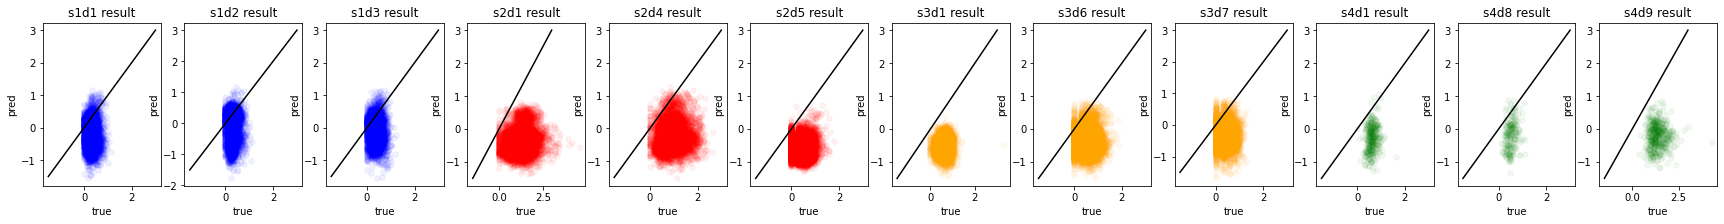

Epoch  100 s1d1:  1.5565733 s1d2:  2.020451 s1d3:  1.3575867 s2d1: 1.3184403 s2d4: 2.2561433 s2d5: 0.6984238 s3d1: 0.21901698 s3d6: 0.93730026 s3d7: 0.7670668 s4d1: 2.2172663 s4d8: 2.849493 s4d9: 3.289381 test loss: 2.8790946655729095
Epoch  200 s1d1:  1.478719 s1d2:  1.938356 s1d3:  1.284382 s2d1: 1.2596892 s2d4: 2.1876984 s2d5: 0.63327473 s3d1: 0.20768574 s3d6: 0.8755693 s3d7: 0.697729 s4d1: 2.1407354 s4d8: 2.7736466 s4d9: 3.2114217 test loss: 2.803013562695302
Epoch  300 s1d1:  1.413159 s1d2:  1.8698975 s1d3:  1.2209727 s2d1: 1.2068458 s2d4: 2.1247685 s2d5: 0.58033895 s3d1: 0.20209944 s3d6: 0.82202756 s3d7: 0.6417002 s4d1: 2.0742593 s4d8: 2.7062852 s4d9: 3.142898 test loss: 2.7362438208630926
Epoch  400 s1d1:  1.3588885 s1d2:  1.8133241 s1d3:  1.1678318 s2d1: 1.1615064 s2d4: 2.0710094 s2d5: 0.5382882 s3d1: 0.19876121 s3d6: 0.7778607 s3d7: 0.5974931 s4d1: 2.018681 s4d8: 2.6499321 s4d9: 3.0852933 test loss: 2.6802787784155435
Epoch  500 s1d1:  1.3149449 s1d2:  1.7672571 s1d3:  1.12459

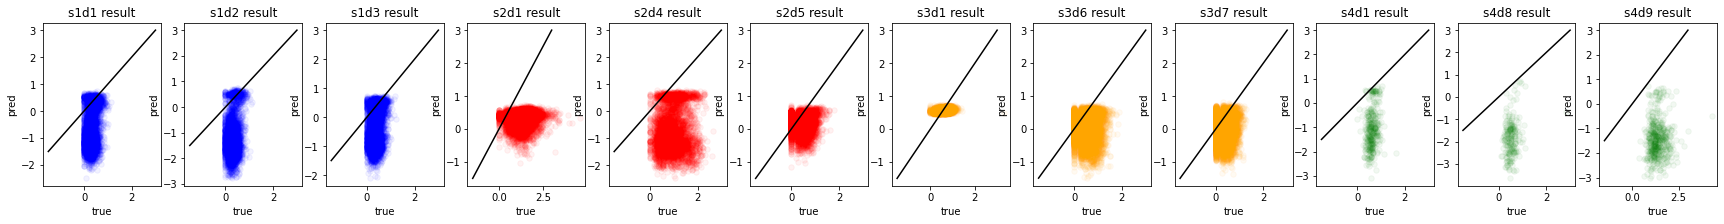

Epoch  1100 s1d1:  1.1798588 s1d2:  1.624107 s1d3:  0.990134 s2d1: 1.0100504 s2d4: 1.8868028 s2d5: 0.42074478 s3d1: 0.19357681 s3d6: 0.63954574 s3d7: 0.4719588 s4d1: 1.8317751 s4d8: 2.4570558 s4d9: 2.888383 test loss: 2.4899223241984862
Epoch  1200 s1d1:  1.1697263 s1d2:  1.6132047 s1d3:  0.9796924 s2d1: 1.0015092 s2d4: 1.8760799 s2d5: 0.41568628 s3d1: 0.19346811 s3d6: 0.63244015 s3d7: 0.46635005 s4d1: 1.8210291 s4d8: 2.4456067 s4d9: 2.8767898 test loss: 2.478771005638636
Epoch  1300 s1d1:  1.1617396 s1d2:  1.6046174 s1d3:  0.97138834 s2d1: 0.99491024 s2d4: 1.8676379 s2d5: 0.4119063 s3d1: 0.19342126 s3d6: 0.6269627 s3d7: 0.4621013 s4d1: 1.8125982 s4d8: 2.4366238 s4d9: 2.8676715 test loss: 2.4700106901254095
Epoch  1400 s1d1:  1.1555591 s1d2:  1.5979658 s1d3:  0.96500325 s2d1: 0.9896809 s2d4: 1.8610134 s2d5: 0.40909064 s3d1: 0.19337195 s3d6: 0.6227781 s3d7: 0.45894042 s4d1: 1.8060539 s4d8: 2.429628 s4d9: 2.8605857 test loss: 2.4632022843799115
Epoch  1500 s1d1:  1.1507232 s1d2:  1.59273

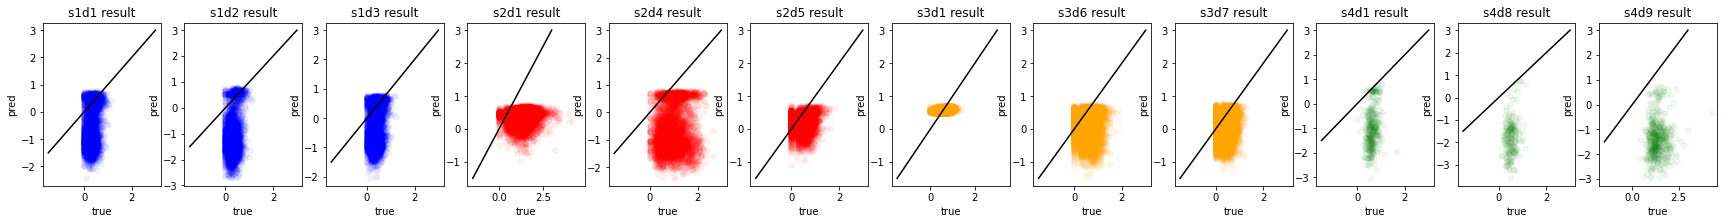

Epoch  2100 s1d1:  1.1374228 s1d2:  1.5785371 s1d3:  0.9455002 s2d1: 0.97322863 s2d4: 1.840444 s2d5: 0.4009675 s3d1: 0.19320008 s3d6: 0.6104914 s3d7: 0.45032975 s4d1: 1.7866089 s4d8: 2.4084775 s4d9: 2.8387141 test loss: 2.442465044335674
Epoch  2200 s1d1:  1.1364337 s1d2:  1.577526 s1d3:  0.9443253 s2d1: 0.9721188 s2d4: 1.8390691 s2d5: 0.40049523 s3d1: 0.19315961 s3d6: 0.60976315 s3d7: 0.44990206 s4d1: 1.7854477 s4d8: 2.407241 s4d9: 2.8373127 test loss: 2.4411813462814966
Epoch  2300 s1d1:  1.1355577 s1d2:  1.5766519 s1d3:  0.9433289 s2d1: 0.97116107 s2d4: 1.8378724 s2d5: 0.40005693 s3d1: 0.19313346 s3d6: 0.60909384 s3d7: 0.4494969 s4d1: 1.7844034 s4d8: 2.4061434 s4d9: 2.8360946 test loss: 2.44005229712161
Epoch  2400 s1d1:  1.1345974 s1d2:  1.575675 s1d3:  0.9421749 s2d1: 0.9702011 s2d4: 1.8365898 s2d5: 0.3996085 s3d1: 0.19311112 s3d6: 0.608366 s3d7: 0.44903505 s4d1: 1.7832437 s4d8: 2.4049373 s4d9: 2.834739 test loss: 2.4387995948812753
Epoch  2500 s1d1:  1.1338435 s1d2:  1.5749197 s1

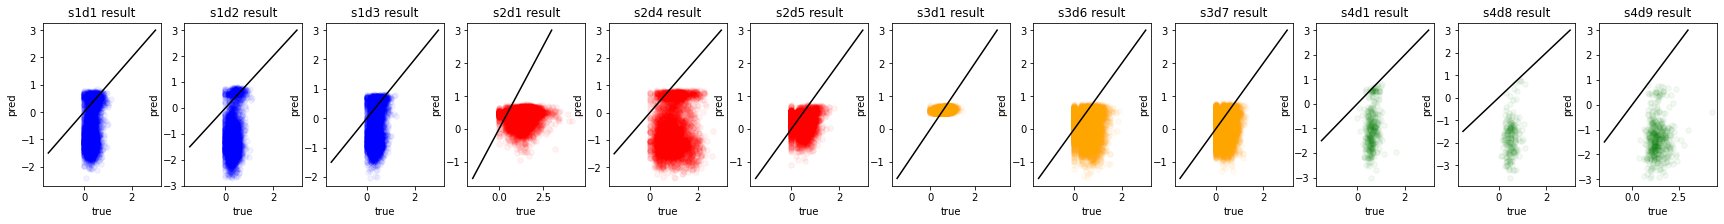

Epoch  3100 s1d1:  1.1307386 s1d2:  1.5721501 s1d3:  0.93742776 s2d1: 0.96534634 s2d4: 1.8304492 s2d5: 0.39750403 s3d1: 0.19295157 s3d6: 0.60497993 s3d7: 0.44715124 s4d1: 1.7779094 s4d8: 2.3998342 s4d9: 2.8285823 test loss: 2.433170604479301
Epoch  3200 s1d1:  1.1302859 s1d2:  1.5717313 s1d3:  0.9369459 s2d1: 0.96483535 s2d4: 1.8297738 s2d5: 0.39728943 s3d1: 0.19294168 s3d6: 0.6046089 s3d7: 0.44693482 s4d1: 1.7772747 s4d8: 2.3992193 s4d9: 2.8278687 test loss: 2.4325094585293616
Epoch  3300 s1d1:  1.1298944 s1d2:  1.5713629 s1d3:  0.936539 s2d1: 0.9645381 s2d4: 1.8292497 s2d5: 0.3971616 s3d1: 0.19293593 s3d6: 0.6043318 s3d7: 0.44676247 s4d1: 1.7767506 s4d8: 2.3986874 s4d9: 2.8272705 test loss: 2.4319537620564433
Epoch  3400 s1d1:  1.12965 s1d2:  1.5711801 s1d3:  0.9362696 s2d1: 0.96425253 s2d4: 1.8289003 s2d5: 0.3970553 s3d1: 0.19292787 s3d6: 0.60412854 s3d7: 0.44665852 s4d1: 1.7763859 s4d8: 2.3983717 s4d9: 2.8268538 test loss: 2.431577933487634
Epoch  3500 s1d1:  1.1292125 s1d2:  1.570

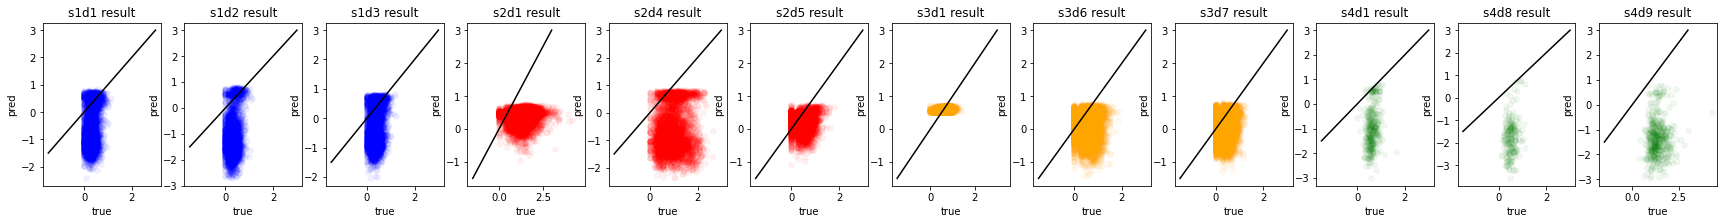

Epoch  4100 s1d1:  1.127949 s1d2:  1.5696454 s1d3:  0.93437874 s2d1: 0.9625626 s2d4: 1.8263353 s2d5: 0.39638668 s3d1: 0.19287112 s3d6: 0.60276806 s3d7: 0.44584456 s4d1: 1.7739475 s4d8: 2.3959637 s4d9: 2.8240952 test loss: 2.429019341251642
Epoch  4200 s1d1:  1.1277045 s1d2:  1.5693871 s1d3:  0.93414044 s2d1: 0.962472 s2d4: 1.8260796 s2d5: 0.39634526 s3d1: 0.19286922 s3d6: 0.60261565 s3d7: 0.4457223 s4d1: 1.7736284 s4d8: 2.3955958 s4d9: 2.8237314 test loss: 2.4286722240668013
Epoch  4300 s1d1:  1.1275076 s1d2:  1.569194 s1d3:  0.93394226 s2d1: 0.9622669 s2d4: 1.8258092 s2d5: 0.39627764 s3d1: 0.1928598 s3d6: 0.6024731 s3d7: 0.44564232 s4d1: 1.7733521 s4d8: 2.3952882 s4d9: 2.823378 test loss: 2.428353475477543
Epoch  4400 s1d1:  1.1273621 s1d2:  1.5690265 s1d3:  0.9338306 s2d1: 0.9622523 s2d4: 1.8256239 s2d5: 0.39626846 s3d1: 0.19285329 s3d6: 0.6024102 s3d7: 0.4455749 s4d1: 1.7731467 s4d8: 2.3949988 s4d9: 2.823141 test loss: 2.4281178199141498
Epoch  4500 s1d1:  1.1273082 s1d2:  1.5690101

In [39]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s3d1, pro_s3d1)

Epoch  0 s1d1:  0.68708247 s1d2:  0.6401046 s1d3:  0.58657676 s2d1: 1.7263327 s2d4: 1.3087503 s2d5: 1.0896887 s3d1: 1.2034422 s3d6: 1.0053399 s3d7: 0.86031115 s4d1: 0.96427584 s4d8: 0.80228823 s4d9: 1.6368697 test loss: 1.2936844870892854


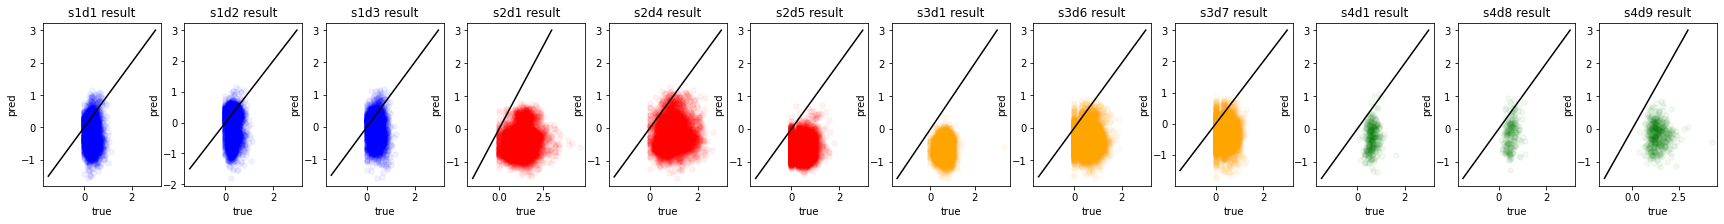

Epoch  100 s1d1:  0.2717277 s1d2:  0.2807617 s1d3:  0.29998964 s2d1: 1.0185723 s2d4: 0.77192235 s2d5: 0.33613843 s3d1: 0.35633358 s3d6: 0.34862757 s3d7: 0.27839577 s4d1: 0.41169584 s4d8: 0.4052964 s4d9: 1.1512338 test loss: 0.8360289450923699
Epoch  200 s1d1:  0.22496447 s1d2:  0.25236577 s1d3:  0.25271177 s2d1: 0.92505616 s2d4: 0.69774026 s2d5: 0.30773416 s3d1: 0.26776853 s3d6: 0.3133704 s3d7: 0.2749395 s4d1: 0.34802178 s4d8: 0.3811846 s4d9: 1.108578 test loss: 0.7966285630992981
Epoch  300 s1d1:  0.22248144 s1d2:  0.24255845 s1d3:  0.24732718 s2d1: 0.896198 s2d4: 0.6806285 s2d5: 0.30462563 s3d1: 0.24057536 s3d6: 0.3072847 s3d7: 0.2808313 s4d1: 0.32499135 s4d8: 0.370022 s4d9: 1.084869 test loss: 0.7770678004143352
Epoch  400 s1d1:  0.22129045 s1d2:  0.23348102 s1d3:  0.24316363 s2d1: 0.88227445 s2d4: 0.67907375 s2d5: 0.30431876 s3d1: 0.22733651 s3d6: 0.3046901 s3d7: 0.28427336 s4d1: 0.31870818 s4d8: 0.36955526 s4d9: 1.0796782 test loss: 0.7728226278314737
Epoch  500 s1d1:  0.22063401 

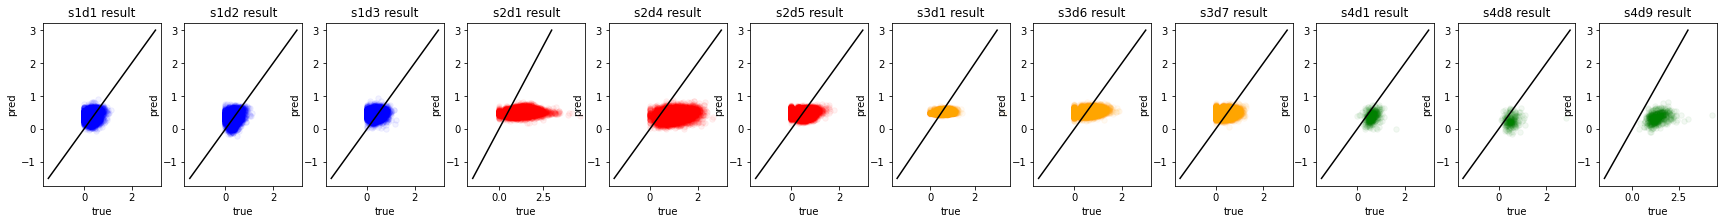

Epoch  1100 s1d1:  0.2209776 s1d2:  0.21839987 s1d3:  0.23375893 s2d1: 0.853354 s2d4: 0.6882701 s2d5: 0.3110814 s3d1: 0.20699355 s3d6: 0.29989067 s3d7: 0.29098853 s4d1: 0.3167868 s4d8: 0.39215958 s4d9: 1.0859069 test loss: 0.7788468841323911
Epoch  1200 s1d1:  0.22087891 s1d2:  0.21828921 s1d3:  0.23288523 s2d1: 0.8513968 s2d4: 0.68996644 s2d5: 0.31175858 s3d1: 0.2063802 s3d6: 0.29958338 s3d7: 0.29176366 s4d1: 0.3184059 s4d8: 0.39624405 s4d9: 1.0893384 test loss: 0.7816896548185435
Epoch  1300 s1d1:  0.22091368 s1d2:  0.21840172 s1d3:  0.23235668 s2d1: 0.84993833 s2d4: 0.69118524 s2d5: 0.31233373 s3d1: 0.20600414 s3d6: 0.29931465 s3d7: 0.2926386 s4d1: 0.3194112 s4d8: 0.39938504 s4d9: 1.0920242 test loss: 0.7838745808282418
Epoch  1400 s1d1:  0.22120188 s1d2:  0.21885337 s1d3:  0.2321018 s2d1: 0.84873253 s2d4: 0.6924697 s2d5: 0.31296736 s3d1: 0.2056684 s3d6: 0.29907772 s3d7: 0.29337627 s4d1: 0.32038522 s4d8: 0.40244898 s4d9: 1.0944836 test loss: 0.785903482857508
Epoch  1500 s1d1:  0.22

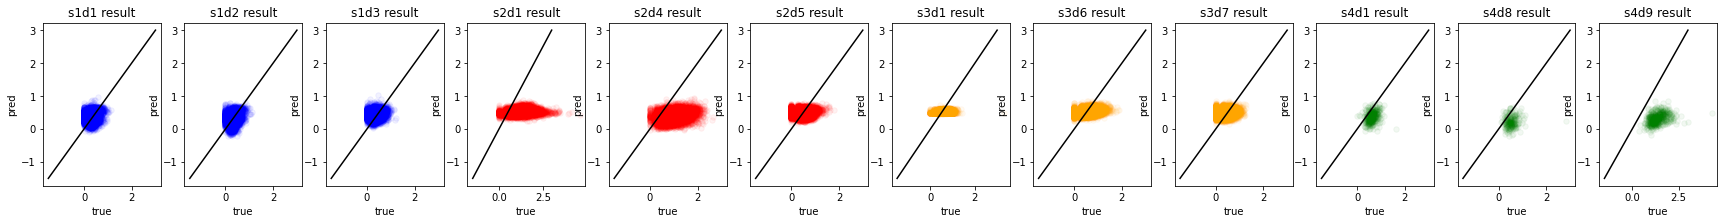

Epoch  2100 s1d1:  0.22328885 s1d2:  0.22118115 s1d3:  0.23191892 s2d1: 0.8432019 s2d4: 0.69734985 s2d5: 0.31579208 s3d1: 0.20448336 s3d6: 0.29789445 s3d7: 0.29756984 s4d1: 0.32612622 s4d8: 0.41869044 s4d9: 1.1091113 test loss: 0.7977718003183412
Epoch  2200 s1d1:  0.22376403 s1d2:  0.22163725 s1d3:  0.23227008 s2d1: 0.8423542 s2d4: 0.69764054 s2d5: 0.31622693 s3d1: 0.20431077 s3d6: 0.2977684 s3d7: 0.29812068 s4d1: 0.32653767 s4d8: 0.42029393 s4d9: 1.1104177 test loss: 0.798835998197897
Epoch  2300 s1d1:  0.22390224 s1d2:  0.22193122 s1d3:  0.23217736 s2d1: 0.8419669 s2d4: 0.69849545 s2d5: 0.31651905 s3d1: 0.20423812 s3d6: 0.2976575 s3d7: 0.29846248 s4d1: 0.32740957 s4d8: 0.42212498 s4d9: 1.1123651 test loss: 0.8003971027356026
Epoch  2400 s1d1:  0.22404869 s1d2:  0.22200201 s1d3:  0.23204836 s2d1: 0.8414335 s2d4: 0.69900906 s2d5: 0.31670386 s3d1: 0.20409513 s3d6: 0.2975587 s3d7: 0.29879895 s4d1: 0.32814997 s4d8: 0.4238074 s4d9: 1.1141807 test loss: 0.8018401980151001
Epoch  2500 s1d1:

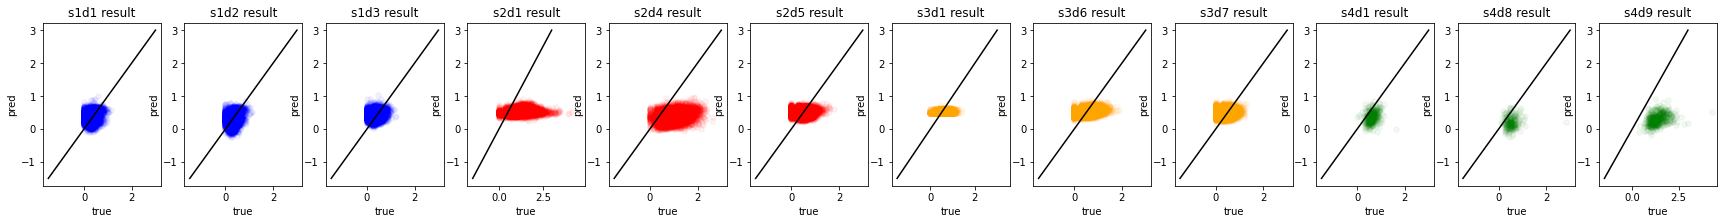

Epoch  3100 s1d1:  0.22434165 s1d2:  0.22296894 s1d3:  0.23131606 s2d1: 0.8388682 s2d4: 0.7036202 s2d5: 0.31835556 s3d1: 0.20351696 s3d6: 0.29694262 s3d7: 0.30085227 s4d1: 0.33286977 s4d8: 0.43355846 s4d9: 1.125093 test loss: 0.8105160498031583
Epoch  3200 s1d1:  0.22465444 s1d2:  0.22325987 s1d3:  0.23163652 s2d1: 0.83850175 s2d4: 0.70354944 s2d5: 0.3185443 s3d1: 0.20341122 s3d6: 0.29686403 s3d7: 0.30118054 s4d1: 0.33273467 s4d8: 0.4338171 s4d9: 1.1254551 test loss: 0.810756910912266
Epoch  3300 s1d1:  0.22468548 s1d2:  0.22345442 s1d3:  0.23164181 s2d1: 0.83836347 s2d4: 0.7038771 s2d5: 0.31870237 s3d1: 0.20339131 s3d6: 0.2967902 s3d7: 0.30145255 s4d1: 0.33308408 s4d8: 0.434603 s4d9: 1.1264807 test loss: 0.8115453381297351
Epoch  3400 s1d1:  0.22509952 s1d2:  0.22387815 s1d3:  0.23211479 s2d1: 0.8379384 s2d4: 0.7038779 s2d5: 0.31900662 s3d1: 0.2032744 s3d6: 0.29670402 s3d7: 0.30180708 s4d1: 0.33296928 s4d8: 0.43479025 s4d9: 1.1269338 test loss: 0.8118390537362393
Epoch  3500 s1d1:  0.

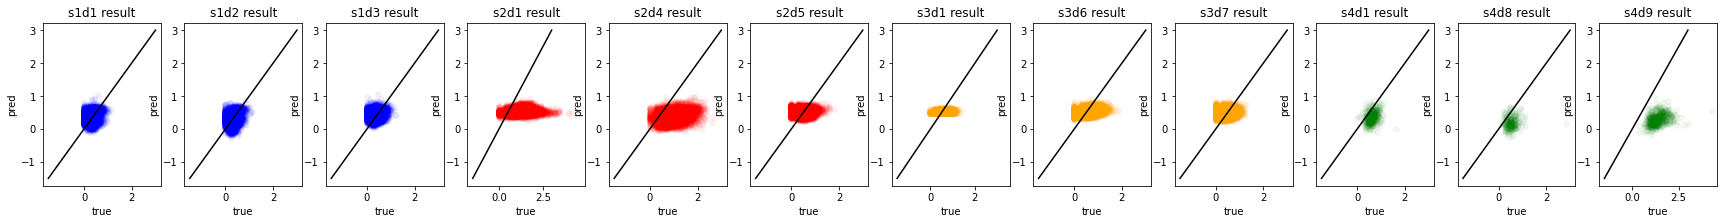

Epoch  4100 s1d1:  0.2256709 s1d2:  0.22411875 s1d3:  0.23264731 s2d1: 0.836897 s2d4: 0.70492536 s2d5: 0.31963733 s3d1: 0.2029619 s3d6: 0.29627037 s3d7: 0.303494 s4d1: 0.3341915 s4d8: 0.43806753 s4d9: 1.1333666 test loss: 0.8164686031896973
Epoch  4200 s1d1:  0.22573668 s1d2:  0.22423035 s1d3:  0.23275407 s2d1: 0.83659655 s2d4: 0.70508164 s2d5: 0.31987152 s3d1: 0.20291114 s3d6: 0.29621473 s3d7: 0.30380264 s4d1: 0.33455765 s4d8: 0.43886712 s4d9: 1.1343776 test loss: 0.8172516648920166
Epoch  4300 s1d1:  0.22583191 s1d2:  0.22441699 s1d3:  0.23285228 s2d1: 0.8364053 s2d4: 0.7054137 s2d5: 0.3200425 s3d1: 0.20285484 s3d6: 0.29616183 s3d7: 0.30396238 s4d1: 0.33483648 s4d8: 0.43941268 s4d9: 1.1351054 test loss: 0.8178141090240947
Epoch  4400 s1d1:  0.22589351 s1d2:  0.22453812 s1d3:  0.23287897 s2d1: 0.8363514 s2d4: 0.705673 s2d5: 0.32014373 s3d1: 0.2028286 s3d6: 0.29611456 s3d7: 0.30407327 s4d1: 0.33522785 s4d8: 0.4400105 s4d9: 1.1358689 test loss: 0.8184205773531423
Epoch  4500 s1d1:  0.22

In [40]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s3d6, pro_s3d6)

Epoch  0 s1d1:  0.68709093 s1d2:  0.6372875 s1d3:  0.588549 s2d1: 1.7282913 s2d4: 1.309408 s2d5: 1.0883121 s3d1: 1.2051791 s3d6: 1.0065056 s3d7: 0.85348564 s4d1: 0.9672082 s4d8: 0.80401796 s4d9: 1.6432917 test loss: 1.2983664663970338


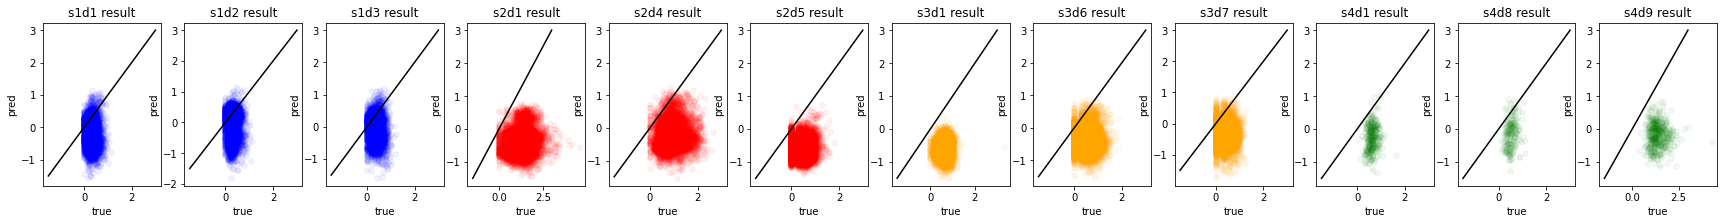

Epoch  100 s1d1:  0.3191147 s1d2:  0.27630776 s1d3:  0.31268784 s2d1: 1.2050505 s2d4: 0.8860755 s2d5: 0.43773347 s3d1: 0.4421139 s3d6: 0.463642 s3d7: 0.27766028 s4d1: 0.5466108 s4d8: 0.46453303 s4d9: 1.3748851 test loss: 1.0060388551376056
Epoch  200 s1d1:  0.26050124 s1d2:  0.23941946 s1d3:  0.26230848 s2d1: 1.1131248 s2d4: 0.8327761 s2d5: 0.37503612 s3d1: 0.36519173 s3d6: 0.41551787 s3d7: 0.255727 s4d1: 0.4882008 s4d8: 0.43923774 s4d9: 1.3222806 test loss: 0.9602445567318036
Epoch  300 s1d1:  0.24013169 s1d2:  0.22359845 s1d3:  0.24297635 s2d1: 1.0807161 s2d4: 0.8184745 s2d5: 0.35548857 s3d1: 0.34114 s3d6: 0.40031856 s3d7: 0.25142196 s4d1: 0.4640406 s4d8: 0.42680988 s4d9: 1.2927012 test loss: 0.9362980726286703
Epoch  400 s1d1:  0.23070747 s1d2:  0.2156772 s1d3:  0.23338412 s2d1: 1.0667413 s2d4: 0.81544125 s2d5: 0.3478423 s3d1: 0.32966226 s3d6: 0.39393926 s3d7: 0.24958341 s4d1: 0.45395386 s4d8: 0.42242658 s4d9: 1.2785449 test loss: 0.9252477893035693
Epoch  500 s1d1:  0.22521776 s1d2

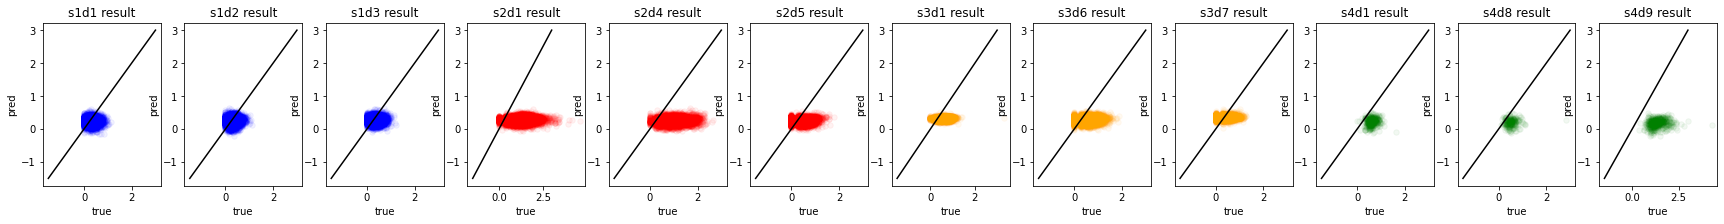

Epoch  1100 s1d1:  0.21654814 s1d2:  0.20769034 s1d3:  0.21941334 s2d1: 1.0485661 s2d4: 0.8260086 s2d5: 0.3387771 s3d1: 0.31230724 s3d6: 0.38413942 s3d7: 0.24647585 s4d1: 0.44445607 s4d8: 0.4213354 s4d9: 1.252592 test loss: 0.9071333980623627
Epoch  1200 s1d1:  0.21608798 s1d2:  0.2079084 s1d3:  0.21916077 s2d1: 1.0478516 s2d4: 0.827062 s2d5: 0.33848894 s3d1: 0.31142297 s3d6: 0.38356388 s3d7: 0.24634036 s4d1: 0.44485617 s4d8: 0.4224052 s4d9: 1.251837 test loss: 0.9068234784553953
Epoch  1300 s1d1:  0.21569793 s1d2:  0.20811738 s1d3:  0.21897736 s2d1: 1.0472032 s2d4: 0.82795304 s2d5: 0.3382192 s3d1: 0.31070694 s3d6: 0.38303643 s3d7: 0.24622758 s4d1: 0.4449633 s4d8: 0.4229809 s4d9: 1.2508532 test loss: 0.9062732930971742
Epoch  1400 s1d1:  0.21538965 s1d2:  0.20822985 s1d3:  0.21885563 s2d1: 1.0466648 s2d4: 0.8289112 s2d5: 0.33788335 s3d1: 0.3099705 s3d6: 0.38267732 s3d7: 0.24613428 s4d1: 0.4452624 s4d8: 0.42371643 s4d9: 1.2501391 test loss: 0.9059411743806037
Epoch  1500 s1d1:  0.215262

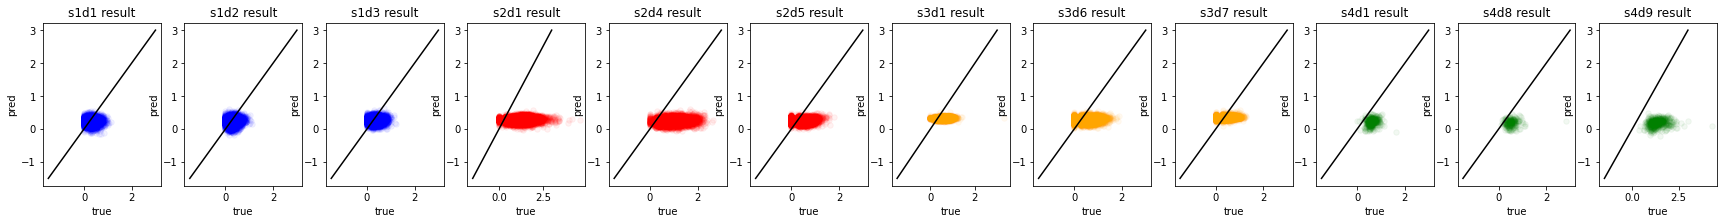

Epoch  2100 s1d1:  0.21409403 s1d2:  0.20821372 s1d3:  0.21796787 s2d1: 1.0428634 s2d4: 0.83112824 s2d5: 0.33591303 s3d1: 0.3068355 s3d6: 0.3802975 s3d7: 0.24564594 s4d1: 0.44558945 s4d8: 0.42700407 s4d9: 1.2456868 test loss: 0.9034960490661134
Epoch  2200 s1d1:  0.2142048 s1d2:  0.20822626 s1d3:  0.21792492 s2d1: 1.0424961 s2d4: 0.83133817 s2d5: 0.33571652 s3d1: 0.3066267 s3d6: 0.38006955 s3d7: 0.24559227 s4d1: 0.44562337 s4d8: 0.42744064 s4d9: 1.2452182 test loss: 0.9032478274981934
Epoch  2300 s1d1:  0.21422409 s1d2:  0.20814893 s1d3:  0.2178371 s2d1: 1.0421813 s2d4: 0.8315373 s2d5: 0.33556125 s3d1: 0.30642965 s3d6: 0.37986314 s3d7: 0.24554315 s4d1: 0.44550923 s4d8: 0.4276187 s4d9: 1.2445658 test loss: 0.9028337153186431
Epoch  2400 s1d1:  0.214473 s1d2:  0.20806882 s1d3:  0.21789363 s2d1: 1.0418097 s2d4: 0.83181834 s2d5: 0.3352401 s3d1: 0.30632907 s3d6: 0.37960348 s3d7: 0.24549717 s4d1: 0.44531244 s4d8: 0.42774352 s4d9: 1.2439061 test loss: 0.9023961171316689
Epoch  2500 s1d1:  0.2

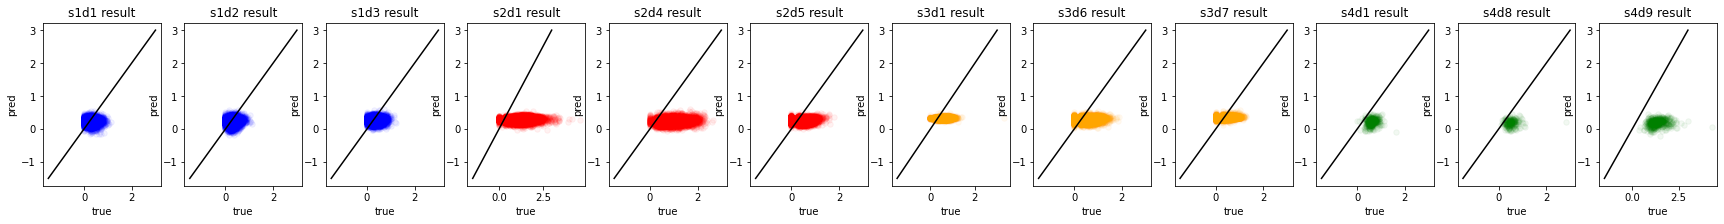

Epoch  3100 s1d1:  0.21437958 s1d2:  0.20699833 s1d3:  0.21755901 s2d1: 1.0400144 s2d4: 0.832941 s2d5: 0.3334622 s3d1: 0.30625653 s3d6: 0.3784966 s3d7: 0.24523908 s4d1: 0.44429135 s4d8: 0.42807797 s4d9: 1.2404583 test loss: 0.9000793927411148
Epoch  3200 s1d1:  0.21424238 s1d2:  0.20680933 s1d3:  0.21737781 s2d1: 1.0396633 s2d4: 0.83284146 s2d5: 0.33323324 s3d1: 0.30624443 s3d6: 0.3783062 s3d7: 0.24520837 s4d1: 0.44407418 s4d8: 0.42802513 s4d9: 1.2399156 test loss: 0.8996951173742769
Epoch  3300 s1d1:  0.21414323 s1d2:  0.20665814 s1d3:  0.21724139 s2d1: 1.0394362 s2d4: 0.83292884 s2d5: 0.3330803 s3d1: 0.30626926 s3d6: 0.3781981 s3d7: 0.24517988 s4d1: 0.44407734 s4d8: 0.42822063 s4d9: 1.2396741 test loss: 0.8995621118623544
Epoch  3400 s1d1:  0.21405193 s1d2:  0.20651531 s1d3:  0.21708857 s2d1: 1.0391289 s2d4: 0.8329792 s2d5: 0.33290523 s3d1: 0.30620807 s3d6: 0.37808192 s3d7: 0.24515115 s4d1: 0.44402263 s4d8: 0.42835173 s4d9: 1.2393537 test loss: 0.8993633461734654
Epoch  3500 s1d1:  0

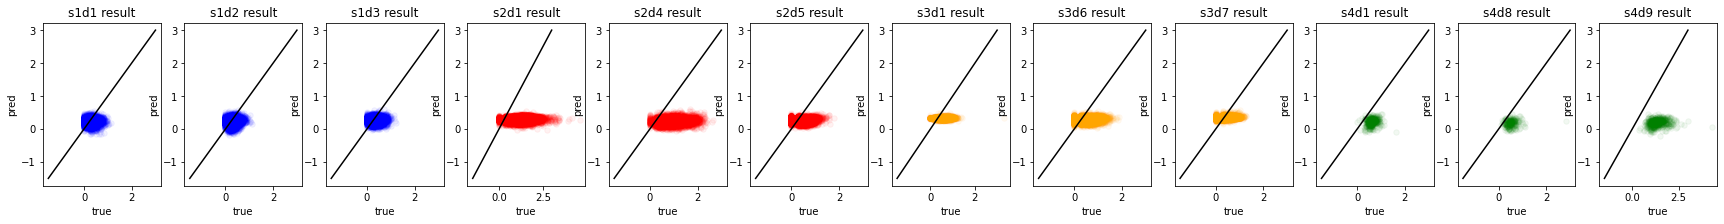

Epoch  4100 s1d1:  0.21535219 s1d2:  0.20737869 s1d3:  0.21713713 s2d1: 1.0373127 s2d4: 0.83510435 s2d5: 0.3320545 s3d1: 0.3060081 s3d6: 0.37745893 s3d7: 0.2449476 s4d1: 0.4451549 s4d8: 0.43120092 s4d9: 1.2388629 test loss: 0.8995217438808938
Epoch  4200 s1d1:  0.21551332 s1d2:  0.20750001 s1d3:  0.2170854 s2d1: 1.0370396 s2d4: 0.83537346 s2d5: 0.33195427 s3d1: 0.30599135 s3d6: 0.37742564 s3d7: 0.2449177 s4d1: 0.44528046 s4d8: 0.431575 s4d9: 1.2387816 test loss: 0.8995282353968065
Epoch  4300 s1d1:  0.21574205 s1d2:  0.20758231 s1d3:  0.21715754 s2d1: 1.0369709 s2d4: 0.8357139 s2d5: 0.3319085 s3d1: 0.3060526 s3d6: 0.37743056 s3d7: 0.2448915 s4d1: 0.44534066 s4d8: 0.43173152 s4d9: 1.2385397 test loss: 0.8994008668062008
Epoch  4400 s1d1:  0.21604155 s1d2:  0.20775315 s1d3:  0.21729071 s2d1: 1.0368818 s2d4: 0.8361656 s2d5: 0.33184204 s3d1: 0.30607566 s3d6: 0.3774351 s3d7: 0.24486631 s4d1: 0.44567233 s4d8: 0.43231043 s4d9: 1.2387444 test loss: 0.8996426409054751
Epoch  4500 s1d1:  0.21616

In [41]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s3d7, pro_s3d7)